In [1]:
import mne
import pandas as pd
#from EnsambleWrapper import sleep_stage_classification

import os
import mne_bids
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import scipy.io
import matplotlib.pyplot as plt

In [2]:

def salida_predicha(hypno):
    hip = []
    for k, duracion in enumerate(hypno['duration']):
       # n_veces = int(duracion / 30)
        """
        if n_veces == 0 :
            estado = hypno['trial_type'][k]
            hip.extend([estado] * 1)
        else :
        """
        if duracion == 0 or 0.0 :
            n_veces = 1
            estado = hypno['trial_type'][k]
            hip.extend([estado] * n_veces)
        else :
            n_veces = int(duracion / 30)
            estado = hypno['trial_type'][k]
            hip.extend([estado] * n_veces)
        
    return hip

# evaluacion de YASA y GSSC por separado

In [ ]:
# pruebo yasa y gssc con estos DATASETS : 
# no voy a superar los 30 individuos por cada uno


# DatasetCollegeDublin
# DataseSleep-Casset
# DatasetDODH
# DatasetSHHS1
# CNTR_VMA_NOCHE-BIDS

In [4]:
# directorio c los dataset que voy a probar
dic_dublin =r'H:\Mi unidad\FormatoBIDS\DatasetCollegeDublin'
dic_SC = r'H:\Mi unidad\FormatoBIDS\DataseSleep-Casset'# el sujeto 003 en sc no carga el edf
dic_DODH =  r'H:\Mi unidad\FormatoBIDS\DatasetDODH'
dic_SHHS1 = r'H:\Mi unidad\FormatoBIDS\DatasetSHHS1'

dic_agus = r'H:\.shortcut-targets-by-id\1oz7_KTs_0LBRN7CMTRkLDKYI--PGbP_t\CNTR_VMA_NOCHE-BIDS_copy'  # señal
path_agus = r'H:\.shortcut-targets-by-id\1epHQ10lpZXvKpjB3tVz3XnAwTgWm38El\SUENIO'  # polisomnografia


directorios = [dic_dublin, dic_SC, dic_DODH, dic_SHHS1]

In [4]:
# preparando metadata para cada dataset
metadatadublin = {'channels' : { 'eog' : [ 'RightEye','Lefteye' ], 'eeg': {'central':['C3A2', 'C4A1'],'frontal' : [], 'parietal' : []}, 'emg':['EMG'] }}
metadataSC = {'channels' : { 'eog' : ['EOG horizontal' ], 'eeg': {'central':[],'frontal' : ['EEG Fpz-Cz'], 'parietal' : ['EEG Pz-Oz']}, 'emg':['EMG submental'] }}
metadataDODH = {'channels' : { 'eog' : ['EOG1', 'EOG2' ], 'eeg': {'central':['C3_M2'],'frontal' : ['F3_M2', 'F4_M1', 'FP1_M2', 'FP2_M1'], 'parietal' : []}, 'emg':['EMG'] }}
metadataSHHS1  = {'channels' : { 'eog' : ['EOG(L)', 'EOG(R)' ], 'eeg': {'central':['EEG', 'EEG(sec)'],'frontal' : [], 'parietal' : []}, 'emg':['EMG'] }}
metadataAgus = {'channels' : { 'eog' : ['EOG1', 'EOG2' ], 'eeg': {'central':['C3', 'Cz','C4'],'frontal' : ['Fz','FC1', 'FC5'], 'parietal' : ['Pz']}, 'emg':['EMG'] }}

In [58]:
k = mne_bids.get_entity_vals(dic_agus, entity_key = 'subject', with_key=True)

In [ ]:


######### clasifico con los 2 clasificadores y guardo las predicciones
metrics = {
    'GSSC': {'accuracy': [], 'f1_macro': [], 'F1_X_clase': []},
    'YASA': {'accuracy': [], 'f1_macro': [], 'F1_X_clase': []}
}

data = []
################ para los datos de agus ###################
for sujeto in mne_bids.get_entity_vals(path_agus, entity_key = 'subject', with_key=True) :
    mapeo_etiquetas = {0: 0, 1: 1, 2: 2, 3: 3 ,5 :4, 4:4, 6: 0, 7:0}

    ruta_salida_deseada = os.path.join(path_agus,sujeto,'ses-day1','sleep_staging',sujeto + '_ses-day1_task-sleep_sleepStages.mat')
    if  os.path.exists(ruta_salida_deseada) :
        y_real__ = scipy.io.loadmat(ruta_salida_deseada)['stageData'][0][0][6][1:] # salida deseada, la del experto
        y_real = np.array([mapeo_etiquetas[etiqueta] for etiqueta in y_real__.flatten()]).reshape(y_real__.shape) # mapeo los datos para que concuerden con la salida de GSSC
        path_sujeto = os.path.join(dic_agus, sujeto,'ses-day1','eeg',sujeto +'_ses-day1_task-sleep_eeg.edf')
        raw =  mne.io.read_raw_edf(path_sujeto, preload =  True)


        # obtengo la salida de GSSC y YASA
        pesos_gssc, y_pred_gssc,  pesos_yasa, y_pred_yasa = sleep_stage_classification(raw, metadataAgus )
        # obtengo la salida real
    
        # recorto para que se ajuste la longitud
        min_length = min( len(y_real),len(y_pred_gssc), len(y_pred_yasa))
        y_pred_gssc = y_pred_gssc[:min_length]

        y_pred_yasa = y_pred_yasa[:min_length]
        
        y_real = y_real[:min_length]

        

        # Calcular métricas para GSSC
        accuracy_gssc = accuracy_score(y_real, y_pred_gssc.tolist())
        f1_macro_gssc = f1_score(y_real, y_pred_gssc.tolist(), average='macro')
        F1_X_clase_gssc = f1_score(y_real, y_pred_gssc.tolist(), average=None)

        # Calcular métricas para YASA
        accuracy_yasa = accuracy_score(y_real, y_pred_yasa)
        f1_macro_yasa = f1_score(y_real, y_pred_yasa, average='macro')
        F1_X_clase_yasa = f1_score(y_real, y_pred_yasa, average=None)

        # Crear un DataFrame a partir del diccionario de métricas

        metrics['GSSC']['accuracy'].append((sujeto,accuracy_gssc) )
        metrics['GSSC']['f1_macro'].append((sujeto,f1_macro_gssc) )
        metrics['GSSC']['F1_X_clase'].append((sujeto,F1_X_clase_gssc ))
        
        metrics['YASA']['accuracy'].append((sujeto,accuracy_yasa) )
        metrics['YASA']['f1_macro'].append((sujeto,f1_macro_yasa ))
        metrics['YASA']['F1_X_clase'].append((sujeto,F1_X_clase_yasa))


        # Agregar los datos del sujeto a la lista
        df_anotacion =  pd.DataFrame(y_pred_gssc.tolist(), columns = ['anotaciones'])
        df_concatenado = pd.concat([pesos_gssc,df_anotacion], axis=1)

        df_anotacion_yasa =  pd.DataFrame(y_pred_yasa.tolist(), columns = ['anotaciones'])
        df_concatenado_yasa = pd.concat([pesos_yasa,df_anotacion_yasa], axis=1)
        # creo la ruta y guardo el df


        path_output_gssc = os.path.join(r"C:\Users\Bruno\OneDrive\Escritorio\Proyecto\AgusGSSC_YASA", f"salida_gssc_{sujeto}.tsv")
        path_output_yasa = os.path.join(r"C:\Users\Bruno\OneDrive\Escritorio\Proyecto\AgusGSSC_YASA", f"salida_yasa_{sujeto}.tsv")


        df_concatenado_yasa.to_csv(path_output_yasa, sep='\t', index=False)
        df_concatenado.to_csv(path_output_gssc, sep='\t', index=False)



In [ ]:
######### clasifico con los 2 clasificadores y guardo las predicciones
metrics = {
    'GSSC': {'accuracy': [], 'f1_macro': [], 'F1_X_clase': []},
    'YASA': {'accuracy': [], 'f1_macro': [], 'F1_X_clase': []}
}
# mapaDublin = {'NREM1' : 1, 'NREM2': 2, 'NREM3': 3,'NREM4': 3, 'REM':4, 'Wake':0, 'NO_DETECTADO' : 0}
# mapaSC = {'NREM1' : 1, 'NREM2': 2, 'NREM3': 3,'NREM4': 3, 'REM':4,'NREM4': 3, 'WAKE':0,'NO_DETECTADO' : 0,'Movement time' : 0}
#mapaSHHS1 = {'NREM1' :1, 'NREM2':2, 'NREM3':3, 'NREM4' : 3, 'REM':4, 'WAKE':0, 'NO_DETECTADO' : 0, 'ARTEFACTO' : 0}
mapaDODH = {'NREM1' :1, 'NREM2':2, 'NREM3':3, 'NREM4' : 3, 'REM':4, 'WAKE':0,'NO_IDENTIFICADO' : 0}
   
# Crear una lista para almacenar los datos de cada sujeto
data = []
sujetos = mne_bids.get_entity_vals(dic_DODH, entity_key = 'subject', with_key=True)

 

for sujeto in sujetos: 
    #luego leo los raw y seteo el canal de eeg eog y emg correcto 
    path_sujeto = os.path.join(dic_DODH, sujeto,'ses-001','eeg',sujeto +'_'+ 'ses-001'+'_task-sleep_eeg.edf')
    raw =  mne.io.read_raw_edf(path_sujeto, preload =  True)
    path_annot = os.path.join(dic_DODH, sujeto,'ses-001','eeg',sujeto +'_'+ 'ses-001'+'_task-sleep_events.tsv')
    anotaciones_real  = pd.read_csv(path_annot, sep  = '\t')

    # raw.set_channel_types( {'RightEye': 'eog', 'Lefteye': 'eog', 'EMG': 'emg', 'C3A2': 'eeg', 'C4A1': 'eeg'})  # para DUBLIN
    
    # obtengo la salida de GSSC y YASA
    pesos_gssc, y_pred_gssc,  pesos_yasa, y_pred_yasa = sleep_stage_classification(raw, metadataDODH )
    # obtengo la salida real
   
    #y_real = [int(mapaDublin.get(data)) for data in anotaciones_real['trial_type']] # dublin
    hipno = salida_predicha(anotaciones_real)
    y_real =[int(mapaDODH.get(data)) for data in hipno]

    # recorto para que se ajuste la longitud
    min_length = min( len(y_real),len(y_pred_gssc), len(y_pred_yasa))
    y_pred_gssc = y_pred_gssc[:min_length]

    y_pred_yasa = y_pred_yasa[:min_length]
    
    y_real = y_real[:min_length]

    

    # Calcular métricas para GSSC
    accuracy_gssc = accuracy_score(y_real, y_pred_gssc.tolist())
    f1_macro_gssc = f1_score(y_real, y_pred_gssc.tolist(), average='macro')
    F1_X_clase_gssc = f1_score(y_real, y_pred_gssc.tolist(), average=None)

    # Calcular métricas para YASA
    accuracy_yasa = accuracy_score(y_real, y_pred_yasa)
    f1_macro_yasa = f1_score(y_real, y_pred_yasa, average='macro')
    F1_X_clase_yasa = f1_score(y_real, y_pred_yasa, average=None)

    # Crear un DataFrame a partir del diccionario de métricas

    metrics['GSSC']['accuracy'].append((sujeto,accuracy_gssc) )
    metrics['GSSC']['f1_macro'].append((sujeto,f1_macro_gssc) )
    metrics['GSSC']['F1_X_clase'].append((sujeto,F1_X_clase_gssc ))
    
    metrics['YASA']['accuracy'].append((sujeto,accuracy_yasa) )
    metrics['YASA']['f1_macro'].append((sujeto,f1_macro_yasa ))
    metrics['YASA']['F1_X_clase'].append((sujeto,F1_X_clase_yasa))


    # Agregar los datos del sujeto a la lista
    df_anotacion =  pd.DataFrame(y_pred_gssc.tolist(), columns = ['anotaciones'])
    df_concatenado = pd.concat([pesos_gssc,df_anotacion], axis=1)

    df_anotacion_yasa =  pd.DataFrame(y_pred_yasa.tolist(), columns = ['anotaciones'])
    df_concatenado_yasa = pd.concat([pesos_yasa,df_anotacion_yasa], axis=1)
    # creo la ruta y guardo el df


    path_output_gssc = os.path.join(r"C:\Users\Bruno\OneDrive\Escritorio\Proyecto\DODHGSSC_YASA", f"salida_gssc_{sujeto}.tsv")
    path_output_yasa = os.path.join(r"C:\Users\Bruno\OneDrive\Escritorio\Proyecto\DODHGSSC_YASA", f"salida_yasa_{sujeto}.tsv")


    df_concatenado_yasa.to_csv(path_output_yasa, sep='\t', index=False)
    df_concatenado.to_csv(path_output_gssc, sep='\t', index=False)








In [73]:

df_accuracy = pd.DataFrame(metrics['YASA']['accuracy'], columns=['sujeto',  'accuracy']) # reordeno el diccionario dsplos combino con merge
df_F1xclase = pd.DataFrame( metrics['YASA']['F1_X_clase'], columns=['sujeto',  'F1_X_clase']) # reordeno el diccionario dsplos combino con merge
df_f1_macro = pd.DataFrame( metrics['YASA']['f1_macro'], columns=['sujeto',  'f1_macro']) # reordeno el diccionario dsplos combino con merge

df_accuracy2 = pd.DataFrame(metrics['GSSC']['accuracy'], columns=['sujeto',  'accuracy']) # reordeno el diccionario dsplos combino con merge
df_F1xclase2 = pd.DataFrame( metrics['GSSC']['F1_X_clase'], columns=['sujeto',  'F1_X_clase']) # reordeno el diccionario dsplos combino con merge
df_f1_macro2 = pd.DataFrame( metrics['GSSC']['f1_macro'], columns=['sujeto',  'f1_macro']) # reordeno el diccionario dsplos combino con merge

df_finalyasa = df_accuracy.merge(df_F1xclase, on=['sujeto']).merge(df_f1_macro, on=['sujeto'])


df_finalGSSC = df_accuracy2.merge(df_F1xclase2, on=['sujeto']).merge(df_f1_macro2, on=['sujeto'])





In [74]:
#################### guardo estos valores
path_output_gssc = os.path.join(r"C:\Users\Bruno\OneDrive\Escritorio\Proyecto\AgusGSSC_YASA", "salida_gssc_metricas.tsv")
path_output_yasa = os.path.join(r"C:\Users\Bruno\OneDrive\Escritorio\Proyecto\AgusGSSC_YASA", "salida_yasa_metricas.tsv")


df_finalyasa.to_csv(path_output_yasa, sep='\t', index=False)
df_finalGSSC.to_csv(path_output_gssc, sep='\t', index=False)

In [75]:

############# calculo un valor promedio en total ###############

def calcu_valores_promedios(df_fin):
    # Calcular el promedio de 'accuracy' y 'f1_macro'
    accuracy_mean = df_fin['accuracy'].mean()
    f1_macro_mean = df_fin['f1_macro'].mean()

    # Calcular el promedio de cada lista en 'F1_X_clase'
    f1_x_clase_df = pd.DataFrame(df_fin['F1_X_clase'].tolist())

    # Calcular el promedio de cada clase
    f1_x_clase_means = f1_x_clase_df.mean().tolist()

    ################################################
    # Crear un nuevo DataFrame para almacenar los resultados
    results_df = pd.DataFrame({
        'Metric': ['accuracy', 'F1_X_clase_mean', 'f1_macro'],
        'Mean': [accuracy_mean, f1_x_clase_means, f1_macro_mean]
    })
    return results_df
###################### guardo estos valores 

df_gscc = calcu_valores_promedios(df_finalGSSC)
df_yasa = calcu_valores_promedios(df_finalyasa)


path_output_gssc = os.path.join(r"C:\Users\Bruno\OneDrive\Escritorio\Proyecto\AgusGSSC_YASA", "salida_gssc_metricas_promedio.tsv")
path_output_yasa = os.path.join(r"C:\Users\Bruno\OneDrive\Escritorio\Proyecto\AgusGSSC_YASA", "salida_yasa_metricas_promedio.tsv")


df_yasa.to_csv(path_output_yasa, sep='\t', index=False)
df_gscc.to_csv(path_output_gssc, sep='\t', index=False)

# Grafico los pesos de cada dataset 

In [192]:
diragus = r"C:\Users\Bruno\OneDrive\Escritorio\Proyecto\AgusGSSC_YASA"
path_a = os.path.join(diragus,os.listdir(diragus)[2])
pesos_a  = pd.read_csv(path_a, sep  = '\t')


In [143]:
os.listdir(diragus)[2]

'salida_gssc_sub-174.tsv'

In [ ]:
for sujeto in mne_bids.get_entity_vals(path_agus, entity_key = 'subject', with_key=True) :
    mapeo_etiquetas = {0: 0, 1: 1, 2: 2, 3: 3 ,5 :4, 4:4, 6: 0, 7:0}

    ruta_salida_deseada = os.path.join(path_agus,sujeto,'ses-day1','sleep_staging',sujeto + '_ses-day1_task-sleep_sleepStages.mat')
    if  os.path.exists(ruta_salida_deseada) :
        y_real__ = scipy.io.loadmat(ruta_salida_deseada)['stageData'][0][0][6][1:] # salida deseada, la del experto
        y_real = np.array([mapeo_etiquetas[etiqueta] for etiqueta in y_real__.flatten()]).reshape(y_real__.shape) # mapeo los datos para que concuerden con la salida de GSSC
        path_sujeto = os.path.join(dic_agus, sujeto,'ses-day1','eeg',sujeto +'_ses-day1_task-sleep_eeg.edf')
        raw =  mne.io.read_raw_edf(path_sujeto, preload =  True)


In [140]:
pesos_a

,N1,N2,N3,R,W,anotaciones
0,0.028471,0.013178,0.001707,0.003628,99.953016,0
1,0.094098,0.021460,0.000299,0.000943,99.883199,0
2,0.032280,0.011465,0.001265,0.004558,99.950431,0
3,0.115657,0.036147,0.001200,0.004562,99.842434,0
4,0.177081,0.020032,0.000983,0.005580,99.796325,0
...,...,...,...,...,...,...
952,0.808351,0.320531,0.001809,88.992183,9.877125,4
953,3.496449,0.787491,0.000914,85.358933,10.356214,4
954,0.334345,0.083896,0.000210,0.359107,99.222442,0
955,49.456895,1.740414,0.000288,13.174871,35.627532,1


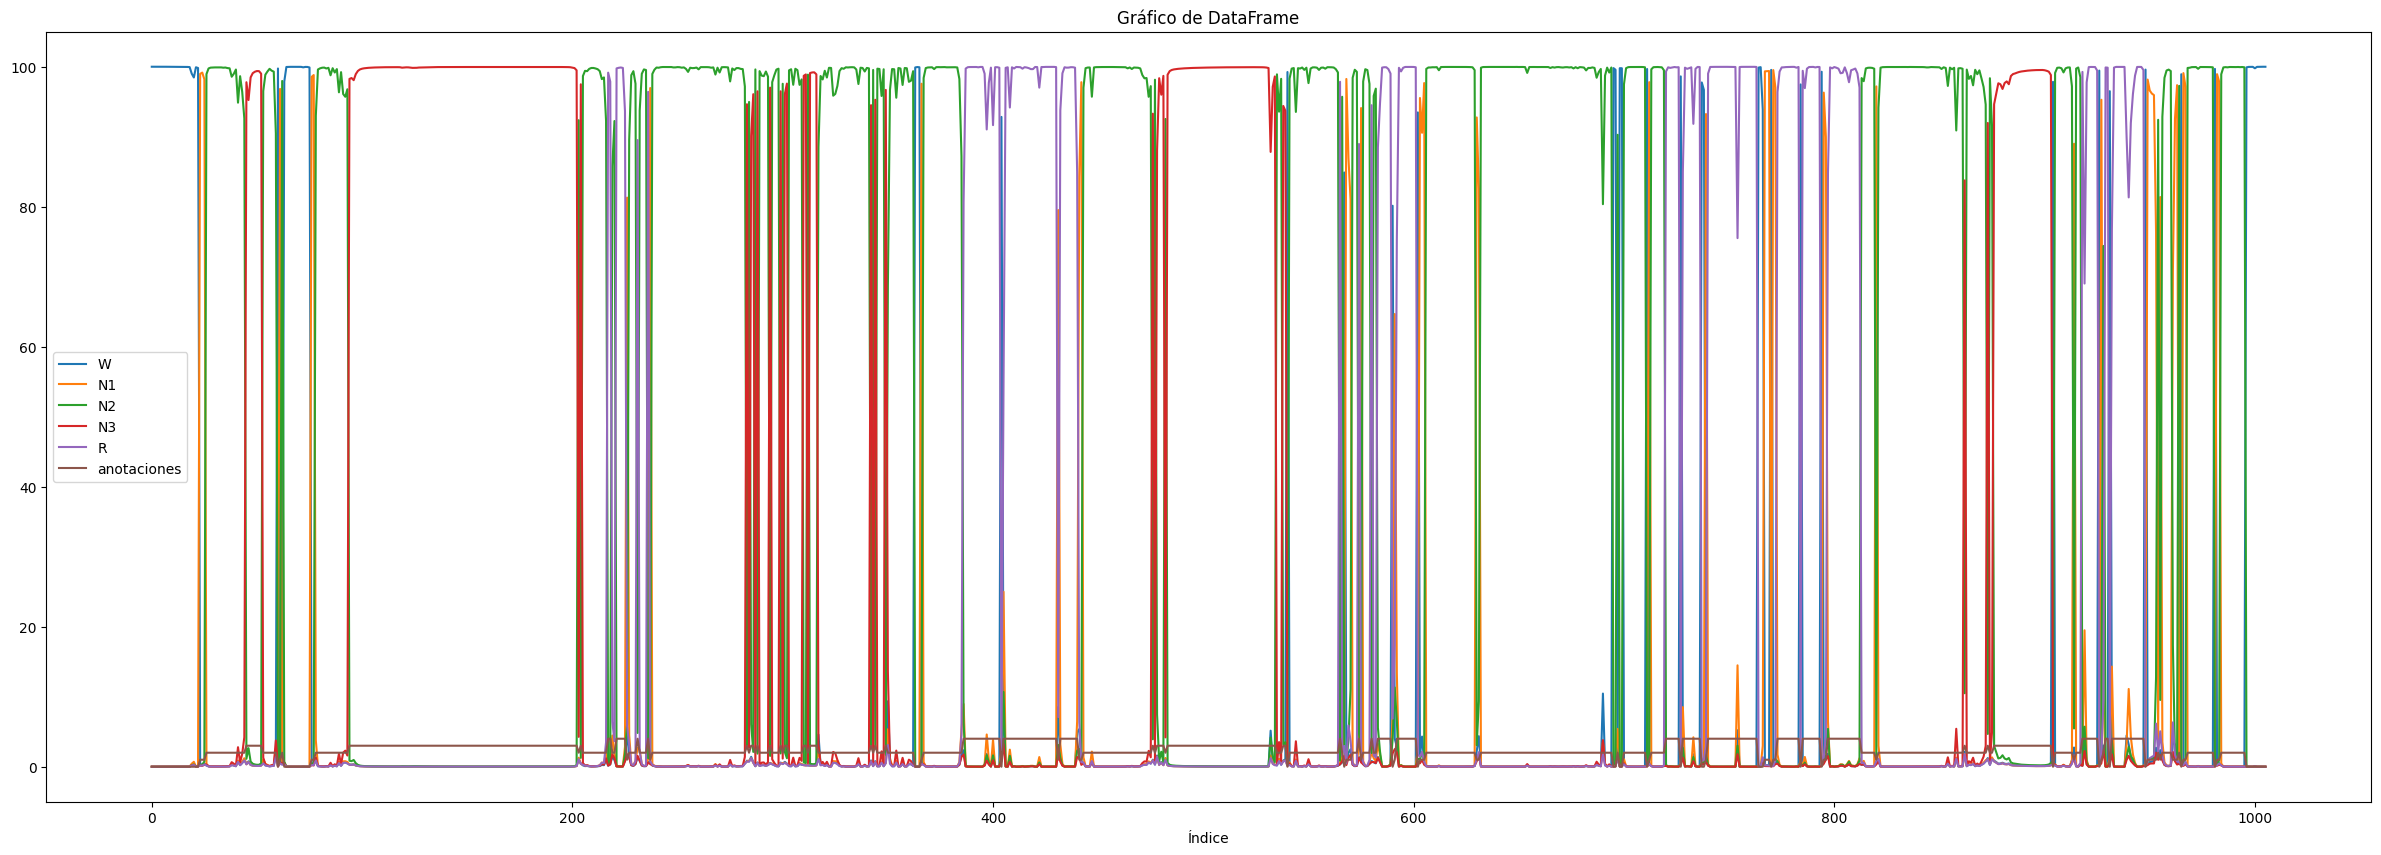

In [145]:



num_columns = len(pesos_a.columns)
fig, axs = plt.subplots( figsize=(30, 10 ))  # Se ha ajustado el tamaño de la figura
pesos_a.plot(kind='line',  ax=axs)  
axs.set_xlabel('Índice')

plt.title('Gráfico de DataFrame')
plt.show()



# Grafico los pesos en una grafica de scatter para cada dataset

In [3]:
# directorio c los dataset que voy a probar
dic_dublin =r'H:\Mi unidad\FormatoBIDS\DatasetCollegeDublin'
dic_SC = r'H:\Mi unidad\FormatoBIDS\DataseSleep-Casset'# el sujeto 003 en sc no carga el edf
dic_DODH =  r'H:\Mi unidad\FormatoBIDS\DatasetDODH'
dic_SHHS1 = r'H:\Mi unidad\FormatoBIDS\DatasetSHHS1'

dic_agus = r'H:\.shortcut-targets-by-id\1oz7_KTs_0LBRN7CMTRkLDKYI--PGbP_t\CNTR_VMA_NOCHE-BIDS_copy'  # señal
path_agus = r'H:\.shortcut-targets-by-id\1epHQ10lpZXvKpjB3tVz3XnAwTgWm38El\SUENIO'

In [120]:
import os
import re
import pandas as pd
###############
#mapaDublin = {'NREM1' : 1, 'NREM2': 2, 'NREM3': 3,'NREM4': 3, 'REM':4, 'Wake':0, 'NO_DETECTADO' : 0}
#mapaSC = {'NREM1' : 1, 'NREM2': 2, 'NREM3': 3,'NREM4': 3, 'REM':4,'NREM4': 3, 'WAKE':0,'NO_DETECTADO' : 0,'Movement time' : 0}
mapaSHHS1 = {'NREM1' :1, 'NREM2':2, 'NREM3':3, 'NREM4' : 3, 'REM':4, 'WAKE':0, 'NO_DETECTADO' : 0, 'ARTEFACTO' : 0}
#mapaDODH = {'NREM1' :1, 'NREM2':2, 'NREM3':3, 'NREM4' : 3, 'REM':4, 'WAKE':0,'NO_IDENTIFICADO' : 0}
###############
# leo los datos obtenidos por los clasificadores
directorio = r'C:\Users\Bruno\OneDrive\Escritorio\Proyecto\SHHS1GSSC_YASA'  ########
os.listdir(directorio)
# Filtrar los archivos que coinciden con el patrón 'sub'
archivos_sub = [archivo for archivo in os.listdir(directorio) if 'sub'  in archivo ]
# Separar los archivos en dos listas: gssc y yasa
archivos_gssc = [archivo for archivo in archivos_sub if 'gssc' in archivo]
archivos_yasa = [archivo for archivo in archivos_sub if 'yasa' in archivo]




# Genero los df con los datos de interes

# Inicializar un DataFrame vacío para almacenar los datos concatenados
concatenated_df_errores = pd.DataFrame()
concatenated_df_aciertos = pd.DataFrame()

patron = re.compile(r'sub-\d+')

# Iterar sobre cada sujeto
for sujeto in archivos_gssc:
    # leo los datos reales 
   
    idx_suj = patron.search(sujeto).group(0)
###############
 ############################## para los datos de la uba uso estas lineas
    """
    mapeo_etiquetas = {0: 0, 1: 1, 2: 2, 3: 3 ,5 :4, 4:4, 6: 0, 7:0}

    ruta_salida_deseada = os.path.join(path_agus,idx_suj,'ses-day1','sleep_staging',idx_suj + '_ses-day1_task-sleep_sleepStages.mat')
    if  os.path.exists(ruta_salida_deseada) :
        y_real__ = scipy.io.loadmat(ruta_salida_deseada)['stageData'][0][0][6][1:] # salida deseada, la del experto
        y_real = np.array([mapeo_etiquetas[etiqueta] for etiqueta in y_real__.flatten()]).reshape(y_real__.shape) # mapeo los datos para que concuerden con la salida de GSSC
    """
    ##############################
###############
    
    path_annot = os.path.join(dic_SHHS1, idx_suj,'ses-001','eeg',idx_suj +'_'+ 'ses-001'+'_task-sleep_events.tsv') #######
    anotaciones_real  = pd.read_csv(path_annot, sep  = '\t')
    hipno = salida_predicha(anotaciones_real)
    y_real =[int(mapaSHHS1.get(data)) for data in hipno] ######

    # Leer el archivo y crear un DataFrame
    data = pd.read_csv(os.path.join(directorio, sujeto), sep='\t')
    print('y_real :', len(y_real), 'data :', len(data['anotaciones']))
    # en este paso me quedo los indices donde el y-real no coincide con las anotaciones de la data, osea donde se confunde el clasificadopr
    idx_errores = [i for i, (real, pred) in enumerate(zip(y_real, data['anotaciones'])) if real != pred]
    idx_aciertos =  [i for i, (real, pred) in enumerate(zip(y_real, data['anotaciones'])) if real == pred]
    df_errores = pd.DataFrame(data).iloc[idx_errores]
    df_acierto = pd.DataFrame(data).iloc[idx_aciertos]
    # Concatenar el DataFrame actual con el DataFrame acumulado
    concatenated_df_errores = pd.concat([concatenated_df_errores, df_errores], axis=0)
    concatenated_df_aciertos = pd.concat([concatenated_df_aciertos, df_acierto], axis=0)


# Reiniciar el índice del DataFrame concatenado
concatenated_df_errores.reset_index(drop=True, inplace=True)
concatenated_df_aciertos.reset_index(drop=True, inplace=True)

# Verificar el DataFrame resultante
df_any_anot_errores =concatenated_df_errores.drop(columns='anotaciones')
df_any_anot_aciertos =concatenated_df_aciertos.drop(columns='anotaciones')


y_real : 1084 data : 1083
y_real : 1079 data : 1078
y_real : 1049 data : 1048
y_real : 728 data : 874
y_real : 1084 data : 1083
y_real : 1084 data : 1083
y_real : 919 data : 918
y_real : 959 data : 958
y_real : 1086 data : 1085
y_real : 1084 data : 1083
y_real : 806 data : 988
y_real : 964 data : 963
y_real : 1086 data : 1085
y_real : 1086 data : 1085
y_real : 959 data : 958
y_real : 1086 data : 1085
y_real : 950 data : 949
y_real : 1084 data : 1083
y_real : 1086 data : 1085
y_real : 1074 data : 1076
y_real : 1072 data : 1071
y_real : 1073 data : 1078
y_real : 929 data : 947
y_real : 929 data : 928
y_real : 910 data : 909
y_real : 1079 data : 1078
y_real : 1017 data : 1019
y_real : 924 data : 923
y_real : 1072 data : 1080
y_real : 1086 data : 1085


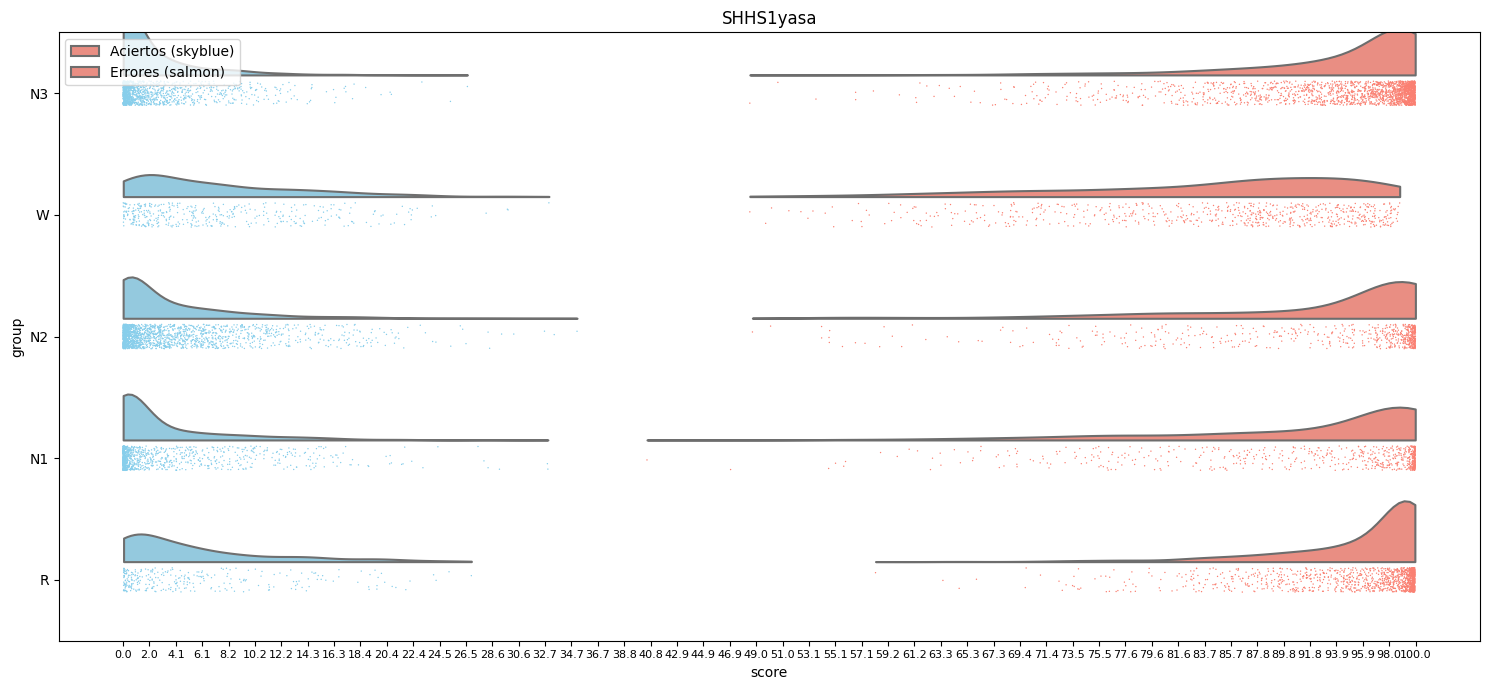

In [118]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ptitprince as pt


########################################### 
# obtener los segundos mejores 
df_any_anot_errores_second = pd.DataFrame()
df_any_anot_errores_second['score'] = df_any_anot_errores.apply(lambda x: x.nlargest(2).iloc[-1], axis=1).tolist()
df_any_anot_errores_second['group']= df_any_anot_errores.apply(lambda x: x.nlargest(2).idxmin(), axis=1).tolist()
#######################################################################

# Obtener el valor máximo y la columna correspondiente para cada fila
df_any_anot_aciertos['max_value'] = df_any_anot_aciertos.max(axis=1)
df_any_anot_aciertos['group'] = df_any_anot_aciertos.idxmax(axis=1)

# Crear un DataFrame solo con los valores máximos y los grupos
df_plot2 = df_any_anot_aciertos[['group', 'max_value']]

# Renombrar las columnas para facilitar la graficación
df_plot2.columns = ['group', 'score']

#######################################################################
# Obtener el valor máximo y la columna correspondiente para cada fila
df_any_anot_errores['max_value'] = df_any_anot_errores.max(axis=1)
df_any_anot_errores['group'] = df_any_anot_errores.idxmax(axis=1)

# Crear un DataFrame solo con los valores máximos y los grupos
df_plot = df_any_anot_errores[['group', 'max_value']]

# Renombrar las columnas para facilitar la graficación
df_plot.columns = ['group', 'score']
#################################################################################
# Configuración del gráfico
f, ax = plt.subplots(figsize=(15, 7))
dy = "group"
dx = "score"
ort = "h"
pal = sns.color_palette(n_colors=5)

# Gráfica de violín y puntos
ax = pt.half_violinplot(data=df_plot, x=dx, y=dy, palette= ['salmon'], bw=.3, cut=0., scale="area", width=1, inner=None, orient=ort)
ax = pt.half_violinplot(data=df_any_anot_errores_second, x=dx, y=dy, palette=['skyblue'], bw=.3, cut=0., scale="area", width=1, inner=None, orient=ort)

#ax = sns.stripplot(data=df_plot, x=dx, y=dy, palette=pal, edgecolor="white", size=1, jitter=1, zorder=0, orient=ort)

# Puntos superpuestos para df_plot
ax = sns.stripplot(data=df_plot, x='score', y='group', color='salmon', edgecolor="white", size=1, jitter=1, zorder=0, orient="h")

# Puntos superpuestos para df_plot2
ax = sns.stripplot(data=df_any_anot_errores_second, x='score', y='group', color='skyblue', edgecolor="white", size=1, jitter=1, zorder=0, orient="h")


# Configuración del eje x
ax.set_xticks(np.linspace(0, 100, 50))
ax.set_title('SHHS1yasa')
ax.tick_params(axis='x', labelsize=8)
ax.legend(['Aciertos (skyblue)', 'Errores (salmon)'], loc='upper left')

# Ajustar los márgenes para evitar que el gráfico se corte
plt.tight_layout()

plt.show()


In [106]:
df_any_anot_errores_second

,group,score
0,0.524536,N3
1,2.097163,N3
2,0.180300,N3
3,0.479438,N3
4,0.864986,N3
...,...,...
5198,7.519870,N3
5199,0.736970,N3
5200,3.779774,N3
5201,3.413767,N3


In [94]:
df_plot2

,group,score
0,W,99.992226
1,W,99.994410
2,W,99.994680
3,W,99.994675
4,W,99.994576
...,...,...
25197,N3,99.950700
25198,N3,99.949005
25199,N3,99.930420
25200,N3,99.923060


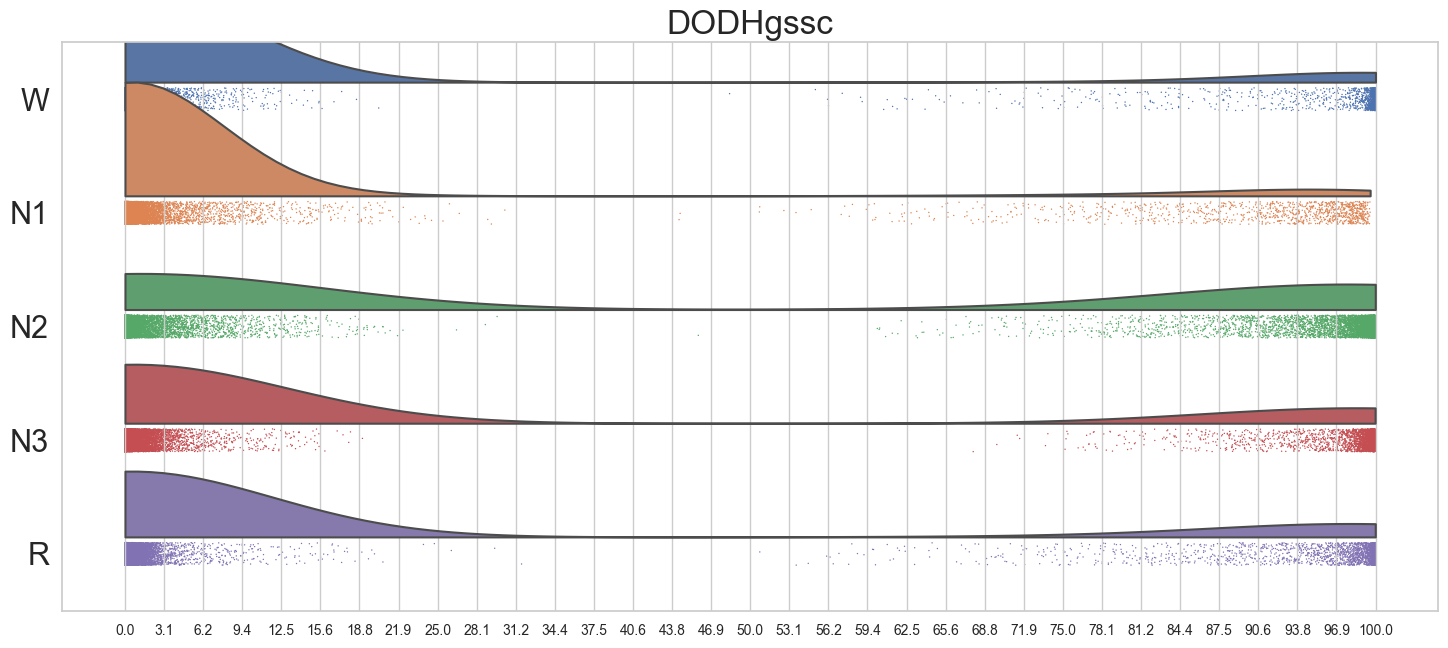

In [15]:

import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
#sns.set(style="darkgrid")
#sns.set(style="whitegrid")
#sns.set_style("white")
sns.set(style="whitegrid",font_scale=2)
import matplotlib.collections as clt

import ptitprince as pt
# plotting the clouds
f, ax = plt.subplots(figsize=(15, 7))
dy="group"; dx="score"; ort="h"; pal = sns.color_palette(n_colors=5)

ax=pt.half_violinplot( data = df_any_anot, palette = pal, bw = .3, cut = 0.,
                      scale = "area", width = 2, inner = None, orient = ort)
ax=sns.stripplot( data = df_any_anot, palette = pal, edgecolor = "white",
                 size = 1, jitter = 1, zorder = 0, orient = ort)

_=ax.set_xticks(np.linspace(0, 100, 33))
_= ax.set_title('DODHgssc')
ax.tick_params(axis='x', labelsize=10) 

# Ajustar los márgenes para evitar que el gráfico se corte
plt.tight_layout()
plt.show()

In [21]:
mapa_anot = {0: 0, 1: 10, 2: 20, 3: 30, 4: 40}
valor = mapa_anot.get(1)
print(valor)

10


In [ ]:

directorio = r'C:\Users\Bruno\OneDrive\Escritorio\Proyecto\ScGSSC_YASA'
os.listdir(directorio)
# Filtrar los archivos que coinciden con el patrón 'sub'
archivos_sub = [archivo for archivo in os.listdir(directorio) if 'sub'  in archivo ]
# Separar los archivos en dos listas: gssc y yasa
archivos_gssc = [archivo for archivo in archivos_sub if 'gssc' in archivo]
archivos_yasa = [archivo for archivo in archivos_sub if 'yasa' in archivo]

patron = re.compile(r'sub-\d+')
mapa_anot = {0: 0, 1: 20, 2: 40, 3: 70, 4: 80}

for sujeto in archivos_gssc:
    df = pd.read_csv(os.path.join(directorio,sujeto), sep = '\t') 
    df['anotaciones']
    plt.figure(figsize=(20, 6))
    plt.scatter(df.index, df['W'], label='W',s=  1)
    plt.scatter(df.index, df['N1'], label='N1',s=  1)
    plt.scatter(df.index, df['N2'], label='N2',s=  1)
    plt.scatter(df.index, df['N3'], label='N3',s=  1)
    plt.scatter(df.index, df['R'], label='R',s=  1)
    anotaciones = [mapa_anot.get(data) for data in df['anotaciones'] ]
    plt.plot(df.index, anotaciones, label='anotacion' ,linewidth=0.5)
    plt.plot(df.index, coincidencias)
    plt.yticks(np.linspace(0, 100, 20)) 

    plt.xlabel('Índice')
    plt.ylabel('Valor')
    idx = patron.search(sujeto)[0]
    plt.title(f'Grafico de pesos con gssc usando SleepCasset :  {idx}')
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), markerscale=10)
    #plt.savefig(rf'C:\Users\Bruno\OneDrive\Escritorio\Proyecto\Pesos\SleepCasset\{idx}.png', bbox_inches='tight')

    plt.show()


In [3]:
############################### Grafica de pesos hipnograma..,. #####################   
mapaDODH = {'NREM1' :1, 'NREM2':2, 'NREM3':3, 'NREM4' : 3, 'REM':4, 'WAKE':0,'NO_IDENTIFICADO' : 0}
# leos las anotaciones reales
data = []
sujetos = mne_bids.get_entity_vals(dic_DODH, entity_key = 'subject', with_key=True)
sujeto = sujetos[0]
path_annot = os.path.join(dic_DODH, sujeto,'ses-001','eeg',sujeto +'_'+ 'ses-001'+'_task-sleep_events.tsv')
anotaciones_real  = pd.read_csv(path_annot, sep  = '\t')

# leo el dataset donde estan losd atos de lsoc los clasificadores 
directorio = r'C:\Users\Bruno\OneDrive\Escritorio\Proyecto\DODHGSSC_YASA'
os.listdir(directorio)
# Filtrar los archivos que coinciden con el patrón 'sub'
archivos_sub = [archivo for archivo in os.listdir(directorio) if 'sub'  in archivo ]
# Separar los archivos en dos listas: gssc y yasa
archivos_gssc = [archivo for archivo in archivos_sub if 'gssc' in archivo]
archivos_yasa = [archivo for archivo in archivos_sub if 'yasa' in archivo]

# leo la saldia del clasificador
data = pd.read_csv(os.path.join(directorio,archivos_gssc[0]), sep = '\t')
data
"""
for sujeto in sujetos: 
    #luego leo los raw y seteo el canal de eeg eog y emg correcto 
    path_sujeto = os.path.join(dic_DODH, sujeto,'ses-001','eeg',sujeto +'_'+ 'ses-001'+'_task-sleep_eeg.edf')
    raw =  mne.io.read_raw_edf(path_sujeto, preload =  True)
    path_annot = os.path.join(dic_DODH, sujeto,'ses-001','eeg',sujeto +'_'+ 'ses-001'+'_task-sleep_events.tsv')
    anotaciones_real  = pd.read_csv(path_annot, sep  = '\t')
"""

# adecuo los datos para que las anotaciones de las etapas sean las mismas
hipno = salida_predicha(anotaciones_real)
y_real =[int(mapaDODH.get(data)) for data in hipno]

# Comparar las dos listas y crear la lista de coincidencias
coincidencias = [0 if real == pred else 100 for real, pred in zip(y_real, data['anotaciones'])]

# Imprimir la lista de coincidencias
print(coincidencias)

NameError: name 'dic_DODH' is not defined

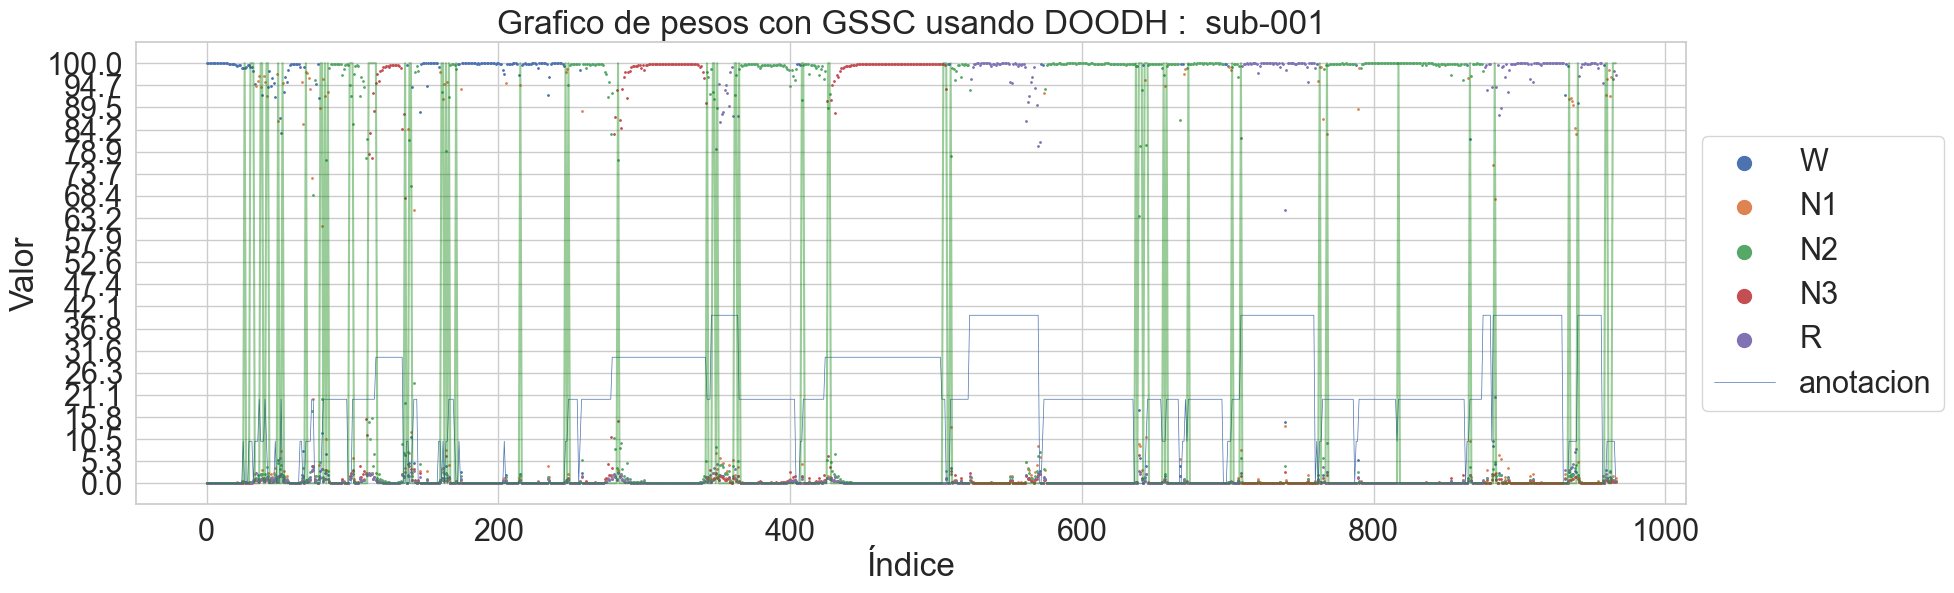

In [184]:
import re
patron = re.compile(r'sub-\d+')
mapa_anot = {0: 0, 1: 20, 2: 40, 3: 70, 4: 80}
directorio = r'C:\Users\Bruno\OneDrive\Escritorio\Proyecto\DODHGSSC_YASA'
os.listdir(directorio)
# Filtrar los archivos que coinciden con el patrón 'sub'
archivos_sub = [archivo for archivo in os.listdir(directorio) if 'sub'  in archivo ]
# Separar los archivos en dos listas: gssc y yasa
archivos_gssc = [archivo for archivo in archivos_sub if 'gssc' in archivo]
archivos_yasa = [archivo for archivo in archivos_sub if 'yasa' in archivo]

# Crear un array de ceros del mismo tamaño que incertidumbre
ventana = np.zeros_like(df.index)

# Definir el tamaño de la ventana
longitud_ventana = 30

# Definir la posición de la ventana (inicio)
inicio = 100
# Asegurarse de que la ventana no se sale de los límites
if inicio + longitud_ventana > ventana.shape[0]:
    raise ValueError("La ventana se sale de los límites del array")

# Llenar la región definida con unos
ventana[inicio:inicio + longitud_ventana] = 100

df = pd.read_csv(os.path.join(directorio,archivos_gssc[0]), sep = '\t') 
df['anotaciones']
plt.figure(figsize=(20, 6))
plt.scatter(df.index, df['W'], label='W',s=  1)
plt.scatter(df.index, df['N1'], label='N1',s=  1)
plt.scatter(df.index, df['N2'], label='N2',s=  1)
plt.scatter(df.index, df['N3'], label='N3',s=  1)
plt.scatter(df.index, df['R'], label='R',s=  1)
anotaciones = [data*10 for data in y_real]
plt.plot(df.index, anotaciones[1:], label='anotacion' ,linewidth=0.5)
plt.plot(df.index, coincidencias, color='green', alpha  = 0.4)


plt.yticks(np.linspace(0, 100, 20)) 

plt.xlabel('Índice')
plt.ylabel('Valor')
idx = patron.search(sujeto)[0]
plt.title(f'Grafico de pesos con GSSC usando DOODH :  {idx}')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), markerscale=10)
#plt.savefig(rf'C:\Users\Bruno\OneDrive\Escritorio\Proyecto\Pesos\SleepCasset\{idx}.png', bbox_inches='tight')

plt.show()

In [82]:
idx

'sub-001'

# Grafico hipnograma

In [253]:
os.path.join(diragus,os.listdir(diragus)[26])

'C:\\Users\\Bruno\\OneDrive\\Escritorio\\Proyecto\\AgusGSSC_YASA\\salida_yasa_sub-174.tsv'

In [218]:
mapeo_etiquetas = {0: 0, 1: 1, 2: 2, 3: 3 ,5 :4, 4:4, 6: 0, 7:0}

ruta_salida_deseada = os.path.join(path_agus,'sub-174','ses-day1','sleep_staging','sub-174' + '_ses-day1_task-sleep_sleepStages.mat')
if  os.path.exists(ruta_salida_deseada) :
    y_real__ = scipy.io.loadmat(ruta_salida_deseada)['stageData'][0][0][6][1:] # salida deseada, la del experto
    y_real = np.array([mapeo_etiquetas[etiqueta] for etiqueta in y_real__.flatten()]).reshape(y_real__.shape) # mapeo los datos para que concuerden con la salida de GSSC
 

In [261]:
diragus = r"C:\Users\Bruno\OneDrive\Escritorio\Proyecto\AgusGSSC_YASA"
path_a = os.path.join(diragus,os.listdir(diragus)[2]) # -174
df_data  = pd.read_csv(path_a, sep  = '\t')
y_predic = df_data['anotaciones']



In [262]:
print(np.unique(y_predic), np.unique(y_real))

[0 1 2 3 4] [0 1 2 3 4]


In [263]:
y_real_ = pd.Series(y_real.flatten().tolist())
y_predic[y_predic == 0 ] = 5
y_real_[y_real_ == 0 ] = 5

c:\Users\Bruno\OneDrive\Escritorio\Proyecto\.venv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [257]:
print(np.unique(y_predic), np.unique(y_real_))

[1 2 3 4 5] [1 2 3 4 5]


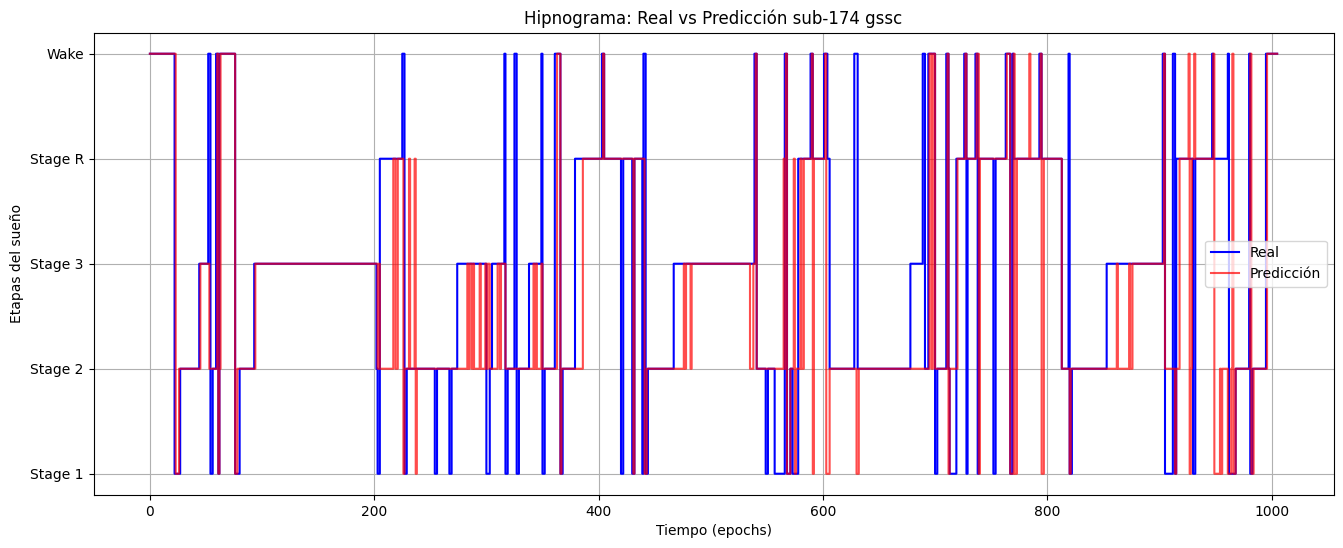

In [265]:
# Crear el hipnograma
plt.figure(figsize=(16, 6))

# Graficar las dos series de datos
plt.plot(y_real_, drawstyle='steps-post', label='Real', color='blue')
plt.plot(y_predic, drawstyle='steps-post', label='Predicción', color='red', alpha=0.7)

# Añadir etiquetas y título
plt.xlabel('Tiempo (epochs)')
plt.ylabel('Etapas del sueño')
plt.title('Hipnograma: Real vs Predicción sub-174 gssc')
plt.yticks([1, 2, 3, 4, 5], ['Stage 1', 'Stage 2', 'Stage 3', 'Stage R', 'Wake'])

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

In [363]:
#############con datos dodh
path_annot = os.path.join(dic_DODH, 'sub-001','ses-001','eeg','sub-001' +'_'+ 'ses-001'+'_task-sleep_events.tsv')
anotaciones_real  = pd.read_csv(path_annot, sep  = '\t')

dirdod = r"C:\Users\Bruno\OneDrive\Escritorio\Proyecto\DODHGSSC_YASA"
path_a = os.path.join(dirdod,os.listdir(dirdod)[29])
df  = pd.read_csv(path_a, sep  = '\t')
y_predic_ = df['anotaciones']


In [343]:
dirdod = r"C:\Users\Bruno\OneDrive\Escritorio\Proyecto\DODHGSSC_YASA"
path_a = os.path.join(dirdod,os.listdir(dirdod)[29])
path_a

'C:\\Users\\Bruno\\OneDrive\\Escritorio\\Proyecto\\DODHGSSC_YASA\\salida_yasa_sub-001.tsv'

In [357]:
anotaciones_real
mapaDODH = {'NREM1' :1, 'NREM2':2, 'NREM3':3, 'NREM4' : 3, 'REM':4, 'WAKE':0,'NO_IDENTIFICADO' : 0}
y_real =[int(mapaDODH.get(data)) for data in salida_predicha(anotaciones_real)
]


#y_predic[y_predic == 0 ] = 5
#y_real_[y_real_ == 0 ] = 5
np.unique(y_real)

array([0, 1, 2, 3, 4])

In [358]:


# recorto para que se ajuste la longitud
min_length = min( len(y_real),len(y_predic))
y_predic = y_predic[:min_length]

y_real = y_real[:min_length]

In [359]:
accuracy_score(y_real,y_predic)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

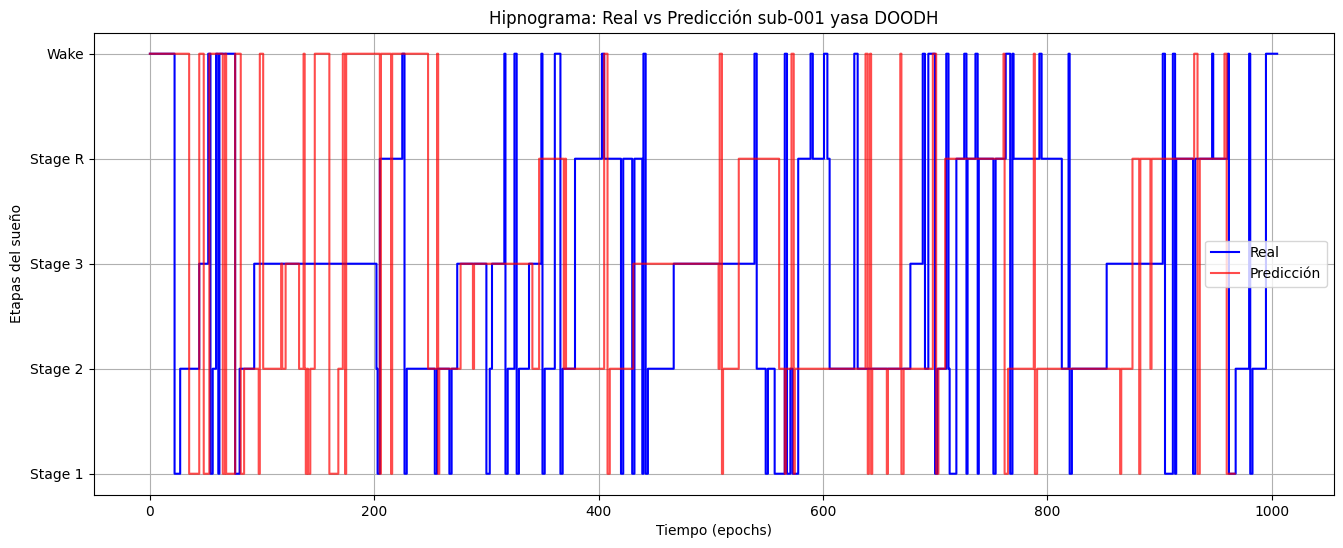

In [346]:
# Crear el hipnograma
plt.figure(figsize=(16, 6))

# Graficar las dos series de datos
plt.plot(y_real_, drawstyle='steps-post', label='Real', color='blue')
plt.plot(y_predic, drawstyle='steps-post', label='Predicción', color='red', alpha=0.7)

# Añadir etiquetas y título
plt.xlabel('Tiempo (epochs)')
plt.ylabel('Etapas del sueño')
plt.title('Hipnograma: Real vs Predicción sub-001 yasa DOODH')
plt.yticks([1, 2, 3, 4, 5], ['Stage 1', 'Stage 2', 'Stage 3', 'Stage R', 'Wake'])

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

# Prueba Deteccion de errores

In [54]:
from ClasificadoresEnsamblados  import ClassifGSSC, ClassifYASA


In [79]:
dic_dod = r'H:\Mi unidad\FormatoBIDS\DatasetDODH'
path = os.path.join(dic_dod, 'sub-001','ses-001','eeg','sub-001' +'_'+ 'ses-001'+'_task-sleep_eeg.edf')
raw = mne.io.read_raw_edf(path, preload =  True)



path_annot = os.path.join(r'H:\Mi unidad\FormatoBIDS\DatasetDODH', sujeto,'ses-001','eeg',sujeto +'_'+ 'ses-001'+'_task-sleep_events.tsv') ###
anotaciones_real  = pd.read_csv(path_annot, sep  = '\t')

hipno = salida_predicha(anotaciones_real)
mapaDODH = {'NREM1' :1, 'NREM2':2, 'NREM3':3, 'NREM4' : 3, 'REM':4, 'WAKE':0,'NO_IDENTIFICADO' : 0}
y_real =[int(mapaDODH.get(data)) for data in hipno]



Extracting EDF parameters from H:\Mi unidad\FormatoBIDS\DatasetDODH\sub-001\ses-001\eeg\sub-001_ses-001_task-sleep_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7259999  =      0.000 ... 29039.996 secs...


In [56]:
def classify_file(raw, metadata, *classifiers ):
    results = {}
    for classifier in classifiers:
        result = classifier(raw, metadata)
        results[classifier.__name__] = result
    return results

def classify_file2(file_data, metadata, classifiers):
    results = {}
    for name, classifier in classifiers.items():
        result = classifier(file_data, metadata)
        results[name] = result
    return results
classifiers = {
    'GSSC': ClassifGSSC, 
    'YASA': ClassifYASA,
    
}

In [59]:

result = classify_file2( raw, metadataDODH, classifiers)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 2751 samples (11.004 sec)



c:\Users\Bruno\OneDrive\Escritorio\Proyecto\.venv\lib\site-packages\gssc\infer.py:117: UserWarning: CUDA was selected but cannot be found on this machine. If you believe this is in error, check your CUDA installation. Otherwise set use_cuda to False.
  warnings.warn("CUDA was selected but cannot be found on this "


Cutting 29.995999999999185 seconds from the back.
Not setting metadata
967 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 967 events and 7501 original time points ...
0 bad epochs dropped
Inferring permutation 1 of 17
Inferring permutation 2 of 17
Inferring permutation 3 of 17
Inferring permutation 4 of 17
Inferring permutation 5 of 17
Inferring permutation 6 of 17
Inferring permutation 7 of 17
Inferring permutation 8 of 17
Inferring permutation 9 of 17
Inferring permutation 10 of 17
Inferring permutation 11 of 17
Inferring permutation 12 of 17
Inferring permutation 13 of 17
Inferring permutation 14 of 17
Inferring permutation 15 of 17
Inferring permutation 16 of 17
Inferring permutation 17 of 17


c:\Users\Bruno\OneDrive\Escritorio\Proyecto\.venv\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 0.22.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [100]:
# Definir los criterios de incertidumbre
criteria = {
    'W': 96,
    'N1': 80,
    'N2': 93,
    'N3': 93,
    'R': 93
}

# Crear una lista para almacenar los resultados de incertidumbre
incertidumbre = []

# Iterar sobre cada fila del DataFrame
for index, row in result['GSSC'][0].iterrows():
    # Encontrar la columna con el valor máximo
    max_col = row.idxmax(axis=0)
    # Comprobar si el valor máximo cumple con el criterio de incertidumbre
    if row[max_col] < criteria[max_col]:
        incertidumbre.append(100)
    else:
        incertidumbre.append(0)

# Agregar la lista de incertidumbre al DataFrame original
num_epocas, num_etapas = result['GSSC'][0].shape
variabilidad = []
diferencia = []
cov = []
ventana = 7
ventana2 = 6
ventana3 = 8
for i in range(0, num_epocas):
    max_pesos = np.max(result['GSSC'][0].iloc[i :i + ventana,:], axis =1)
    max_pesos2 = np.max(result['GSSC'][0].iloc[i :i + ventana2,:], axis =1)
   
    cov_matrix = np.cov(result['GSSC'][0].iloc[i :i + ventana3,:])

In [180]:
variabilidad.index

<function list.index(value, start=0, stop=9223372036854775807, /)>

Text(0.5, 1.0, 'Hipnograma: Real vs Predicción sub-174 gssc')

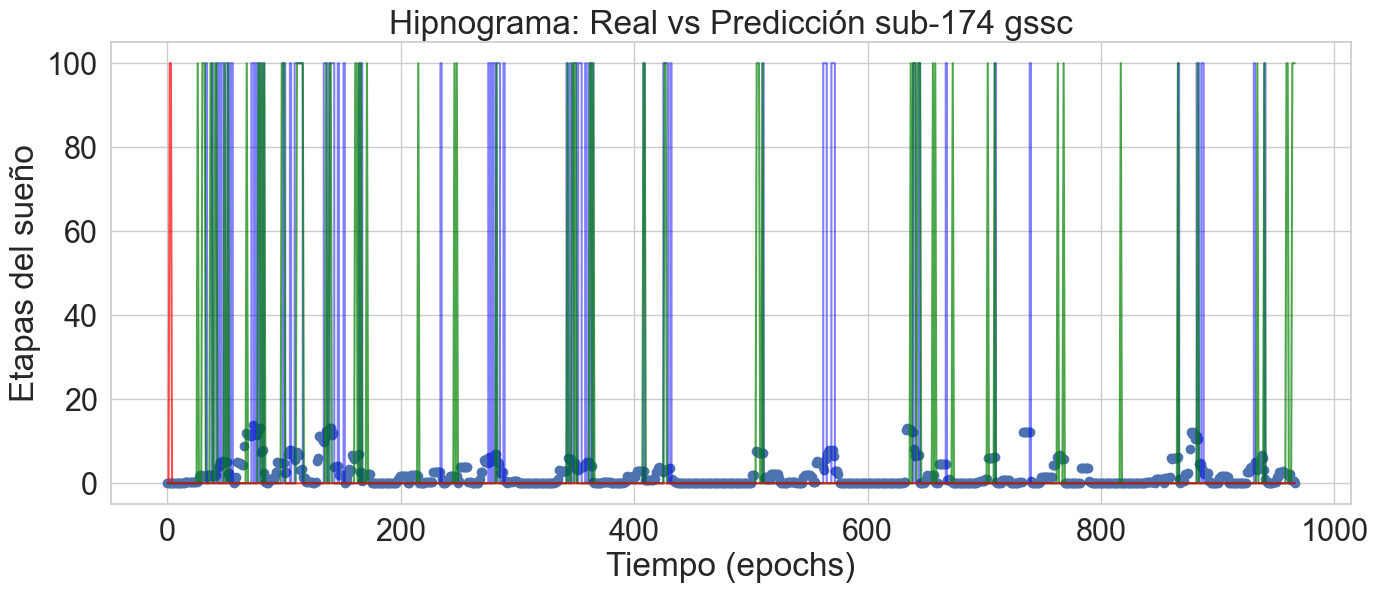

In [289]:
# Crear un array de ceros del mismo tamaño que incertidumbre
ventana = np.zeros_like(incertidumbre)

# Definir el tamaño de la ventana
longitud_ventana = 2

# Definir la posición de la ventana (inicio)
inicio = 2

# Asegurarse de que la ventana no se sale de los límites
if inicio + longitud_ventana > ventana.shape[0]:
    raise ValueError("La ventana se sale de los límites del array")

# Llenar la región definida con unos
ventana[inicio:inicio + longitud_ventana] = 100
################################################################################################################

# comprobando si el criterio de seleccion de errores es bueno ....
plt.figure(figsize=(16, 6))
# Graficar las dos series de datos#
plt.plot(incertidumbre, drawstyle='steps-post', label='Real', color='blue', alpha =0.5)
plt.plot(df.index, coincidencias, color='green', alpha  = 0.7)
plt.plot(ventana, color='red', alpha  = 0.7)
plt.scatter(std_ven.index,variabilidad)

# Añadir etiquetas y título
plt.xlabel('Tiempo (epochs)')
plt.ylabel('Etapas del sueño')
plt.title('Hipnograma: Real vs Predicción sub-174 gssc')

In [254]:
i
num_epocas

max_pesos[i+ventana-2]- max_pesos[i]

1.1284103

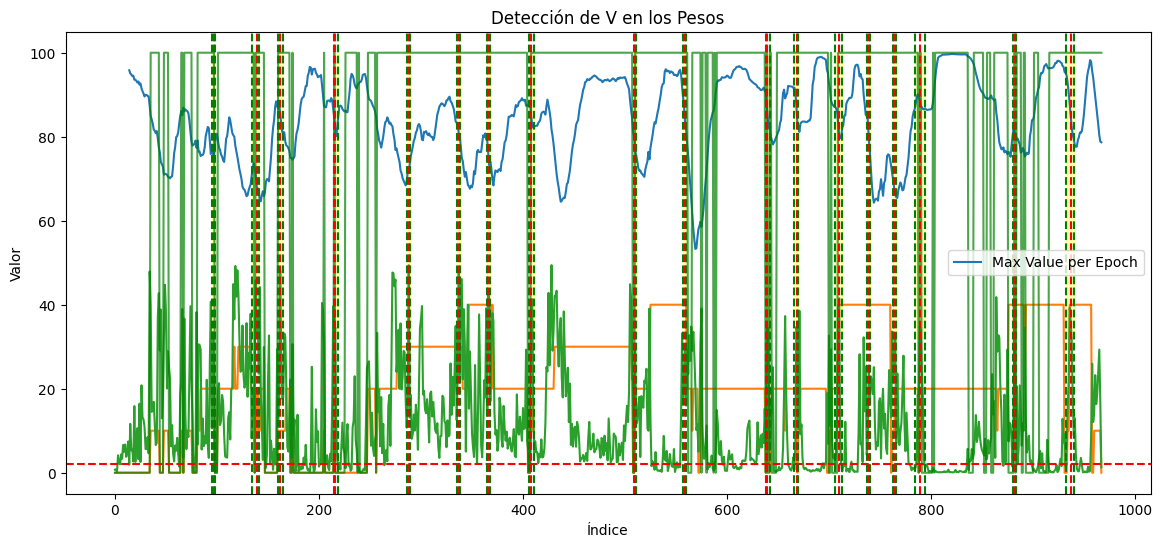

In [127]:
df = result['YASA'][0]
coincidencias = [0 if real == pred else 100 for real, pred in zip(y_real, result['YASA'][1])]

import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt

# Función para detectar las "V" en los datos
def detectar_v(df, umbral=20, min_change=5):
    df_max = df.max(axis=1)
    min_locs = argrelextrema(df_max.values, np.less_equal, order=umbral)[0]
    max_locs = argrelextrema(df_max.values, np.greater_equal, order=1)[0]

    v_segments = []

    for i in range(1, len(min_locs) - 1):
        left_max = max_locs[max_locs < min_locs[i]]
        right_max = max_locs[max_locs > min_locs[i]]

        if len(left_max) > 0 and len(right_max) > 0:
            left_max = left_max[-1]
            right_max = right_max[0]

            if left_max < min_locs[i] < right_max:
                left_value = df_max.iloc[left_max]
                min_value = df_max.iloc[min_locs[i]]
                right_value = df_max.iloc[right_max]

                if left_value - min_value > min_change and right_value - min_value > min_change:
                    v_segments.append((left_max, min_locs[i], right_max))

    return v_segments

# Cargar datos de ejemplo


# Detectar segmentos "V"
v_segments = detectar_v(df, umbral=20, min_change=5)
###########
# Assuming df is a DataFrame and you want the max value across columns for each row
df_max = pd.Series(df.max(axis=1))

# Define the window size for the moving average
window_size = 15

# Apply the rolling mean with the defined window size
df_ventaneado = df_max.rolling(window=window_size).mean()
second_largest_values = df.apply(lambda x: x.nlargest(2).iloc[-1], axis=1).tolist()


###################
# Visualización
plt.figure(figsize=(14, 6))
plt.plot(df_ventaneado.index, df_ventaneado, label='Max Value per Epoch')
plt.plot(result['YASA'][1]*10)
plt.plot(second_largest_values)
plt.plot(df.index, coincidencias, color='green', alpha  = 0.7)
plt.axhline(y=2, color='red', linestyle='--')

for (left_max, min_loc, right_max) in v_segments:
    plt.axvline(x=left_max, color='g', linestyle='--')
    plt.axvline(x=min_loc, color='r', linestyle='--')
    plt.axvline(x=right_max, color='g', linestyle='--')
    plt.fill_betweenx([df.max(axis=1).min(), df.max(axis=1).max()], left_max, right_max, color='yellow', alpha=0.3)

plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Detección de V en los Pesos')
plt.legend()
plt.show()


In [63]:
df_max

0      99.990997
1      99.992073
2      99.991875
3      99.990318
4      99.990089
         ...    
962    92.154320
963    96.673485
964    96.229683
965    98.245125
966    97.284775
Length: 967, dtype: float32

In [ ]:
num_epocas, num_etapas = result['GSSC'][0].shape
anotacion = result['GSSC'][1]
variabilidad = []
diferencia = []
cov = []
ventana = 7
ventana2 = 8
for i in range(0, num_epocas):
    max_pesos = np.max(result['GSSC'][0].iloc[i :i + ventana,:], axis =1)
    max_pesos2 = np.max(result['GSSC'][0].iloc[i :i + ventana2,:], axis =1)
   
   
    std_ventana = np.std(max_pesos) 
    dif = np.mean(max_pesos2) - max_pesos2.iloc[-1]    
    diferencia.append(dif)
    variabilidad.append(np.mean(std_ventana))  
std_ven = pd.Series(variabilidad)

incertdumbre2 = []   # para los std y dif

for i in np.arange(num_epocas):

    if(diferencia[i]<-7 and variabilidad[i]>5 ):
        incertdumbre2.append(100)
    else :
        incertdumbre2.append(0)


In [168]:



#  estimo las epocas mal detectadas ubicando segmentos
def Detec_Classif(data):

    #num_epocas, num_etapas = result['GSSC'][0].shape
    #anotacion = result['GSSC'][1]
    num_epocas = data.shape[0]
    anotacion = data.anotaciones
    incertidumbre3 = []   # evaluo las anotaciones

    ventana_anotacion = 1
    for i in np.arange(num_epocas):
        if i >= ventana_anotacion and i < num_epocas - ventana_anotacion:
            ventana_anterior = anotacion[i-ventana_anotacion:i]
            ventana_posterior = anotacion[i+1:i+ventana_anotacion+1]
            
            # Verificar si todos los elementos en la ventana anterior son diferentes al valor actual
            # y si todos los elementos en la ventana anterior son iguales entre sí
            if (np.all(anotacion[i] != ventana_anterior) and 
                len(np.unique(ventana_anterior)) == 1 and 
                np.all(anotacion[i] == ventana_posterior)):
                incertidumbre3.append(100)
            else:
                incertidumbre3.append(0)  
        else:
            incertidumbre3.append(0) 
    return  incertidumbre3
#######################################
def Detec_Classif2(data):
    
    # Definir los criterios de incertidumbre
    criteria = {
        'W': 98,
        'N1': 0,
        'N2': 96,
        'N3': 97,
        'R': 96
    }

    # Crear una lista para almacenar los resultados de incertidumbre
    incertidumbre = []

    # Iterar sobre cada fila del DataFrame
    for index, row in data.iterrows():
        # Encontrar la columna con el valor máximo
        max_col = row.idxmax(axis=0)
        # Comprobar si el valor máximo cumple con el criterio de incertidumbre
        if row[max_col] < criteria[max_col]:
            incertidumbre.append(100)
        else:
            incertidumbre.append(0)
    return  incertidumbre
def Detec_Classif3_yasa(data):
    
    # Definir los criterios de incertidumbre
    criteria = {
        'N1': 0,
        'N2': 53,
        'N3': 60,
        'R': 60,
        'W': 70
    }

    # Crear una lista para almacenar los resultados de incertidumbre
    incertidumbre = []

    # Iterar sobre cada fila del DataFrame
    for index, row in data.iterrows():
        # Encontrar la columna con el valor máximo
        max_col = row.idxmax(axis=0)
        # Comprobar si el valor máximo cumple con el criterio de incertidumbre
        if row[max_col] < criteria[max_col]:
            incertidumbre.append(100)
        else:
            incertidumbre.append(0)
    return  incertidumbre
def detect_comb_yasa_gssc(anotacion_gssc,anotaciones_yasa, data ):
     # Definir los criterios de incertidumbre
    criteria = {
        'W': 98,
        'N1': 0,
        'N2': 96,
        'N3': 97,
        'R': 96
    }

    # Crear una lista para almacenar los resultados de incertidumbre
    incertidumbre = []
    No_concidencias = [100 if epoch_gssc != epoch_yasa else 0 for epoch_gssc, epoch_yasa in zip(anotacion_gssc, anotaciones_yasa)]
  
    # Iterar sobre cada fila del DataFrame
    for index, row in data.iterrows():

        print(index, len(No_concidencias))
    
        # Encontrar la columna con el valor máximo
        max_col = row.idxmax(axis=0)
        # Comprobar si el valor máximo cumple con el criterio de incertidumbre
        if row[max_col] < criteria[max_col] and No_concidencias[index] == 100:
            incertidumbre.append(100)
        else:
            incertidumbre.append(0)
    return incertidumbre

In [109]:
dic_dublin =r'H:\Mi unidad\FormatoBIDS\DatasetCollegeDublin'
dic_SC = r'H:\Mi unidad\FormatoBIDS\DataseSleep-Casset'# el sujeto 003 en sc no carga el edf

dic_DODH =  r'H:\Mi unidad\FormatoBIDS\DatasetDODH'
dic_SHHS1 = r'H:\Mi unidad\FormatoBIDS\DatasetSHHS1'

dic_agus = r'H:\.shortcut-targets-by-id\1oz7_KTs_0LBRN7CMTRkLDKYI--PGbP_t\CNTR_VMA_NOCHE-BIDS_copy'  # señal
path_agus = r'H:\.shortcut-targets-by-id\1epHQ10lpZXvKpjB3tVz3XnAwTgWm38El\SUENIO'  # polisomnografia

In [159]:

def salida_predicha(hypno):
    hip = []
    for k, duracion in enumerate(hypno['duration']):

        if duracion == 0 or 0.0 :
            n_veces = 1
        else :
            n_veces = int(duracion / 30)
        estado = hypno['trial_type'][k]
        hip.extend([estado] * n_veces)
        
    return hip

In [173]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import re
#mapaDublin = {'NREM1' : 1, 'NREM2': 2, 'NREM3': 3,'NREM4': 3, 'REM':4, 'Wake':0, 'NO_DETECTADO' : 0}
#mapaSC = {'NREM1' : 1, 'NREM2': 2, 'NREM3': 3,'NREM4': 3, 'REM':4,'NREM4': 3, 'WAKE':0,'NO_DETECTADO' : 0,'Movement time' : 0}

#mapaSHHS1 = {'NREM1' :1, 'NREM2':2, 'NREM3':3, 'NREM4' : 3, 'REM':4, 'WAKE':0, 'NO_DETECTADO' : 0, 'ARTEFACTO' : 0}
mapaDODH = {'NREM1' :1, 'NREM2':2, 'NREM3':3, 'NREM4' : 3, 'REM':4, 'WAKE':0,'NO_IDENTIFICADO' : 0}
   
direct = r'C:\Users\Bruno\OneDrive\Escritorio\Proyecto\DODHGSSC_YASA'  ###
# Filtrar los archivos que coinciden con el patrón 'sub'
archivos_sub = [archivo for archivo in os.listdir(direct) if 'sub'  in archivo ]
# Separar los archivos en dos listas: gssc y yasa
archivos_gssc = [archivo for archivo in archivos_sub if 'gssc' in archivo]
archivos_yasa = [archivo for archivo in archivos_sub if 'yasa' in archivo]
patron = re.compile(r'(sub-\d+)\.tsv')
# Extraer las partes deseadas usando la expresión regular
partes_extraidas = [patron.search(archivo).group(1) for archivo in archivos_gssc if patron.search(archivo)]

Score_ventana = []
Score_yasa = []
Score_gssc = []
score_comb = []
Score_conci_umbral=[]
Score_no_concidencias = []
confM = []
confM2 = []


for path_yasa, sujeto, path_gssc in zip(archivos_yasa , partes_extraidas,archivos_gssc):
    # leo los datos de gssc y yasa
    data_gssc = pd.read_csv(os.path.join(direct,path_gssc), sep = '\t')
    data_yasa =  pd.read_csv(os.path.join(direct,path_yasa), sep = '\t')
    # aplico deteccion por cambio en las anotaciones a gssc
    detecciones = Detec_Classif(data_gssc)
    # ovbtengo  las anotaciones a gssc y yasa 
    anotacion_gssc= data_gssc['anotaciones']
    anotaciones_yasa = data_yasa['anotaciones']
    # aplico la sno coincidencia, comparo lasw anoaciones de gssc y yasa, donde no copinciden peude ser que alla un error d clasificacion
    
    No_concidencias = [100 if epoch_gssc != epoch_yasa else 0 for epoch_gssc, epoch_yasa in zip(anotacion_gssc, anotaciones_yasa)]
    
    change_points_detect = [100  if  (data_gssc['anotaciones'][i] != data_gssc['anotaciones'][i-1] or data_gssc['anotaciones'][i] != data_gssc['anotaciones'][i+1] ) else 0 for i in range(1, len(data_gssc['anotaciones'])-1)]
    Detect_comb =  [max(a, b) for a, b in zip(change_points_detect, No_concidencias)]
    # quito  las anotaciones a gssc y yasa 
    data_gssc_drop = data_gssc.drop(columns='anotaciones')
    data_yasa_drop = data_yasa.drop(columns='anotaciones')
    ###########
    # pruebo esto que es aplicar no concidencias y luego ver los umbrales de gssc 
    detecciones_no_concidencia_yumbrales = detect_comb_yasa_gssc(anotacion_gssc,anotaciones_yasa, data_gssc_drop )

    # detecto los errores usando los umbrales de peso apra aysa y gssc por separado
    detecciones2 = Detec_Classif2(data_gssc_drop) # para gssc
    detecciones3 = Detec_Classif3_yasa(data_yasa_drop) # para yasa
   
    # Combinar las listas  asi capturo todos lso errores que peude tener el clasificqador
    lista_combinada = [max(a, b) for a, b in zip(detecciones2, detecciones3)]  # combina la clasificacion de rrores segun umbral de yasa y de gssc al mismo tiempo
   
    # leo la anotacion REAL
    path_annot = os.path.join(dic_DODH, sujeto,'ses-001','eeg',sujeto +'_'+ 'ses-001'+'_task-sleep_events.tsv') ###
    anotaciones_real  = pd.read_csv(path_annot, sep  = '\t')

    hipno = salida_predicha(anotaciones_real)
    
    y_real =[int(mapaDODH.get(data)) for data in hipno] ###    
    
    ############################## para los datos de la uba uso estas lineas
    """
    mapeo_etiquetas = {0: 0, 1: 1, 2: 2, 3: 3 ,5 :4, 4:4, 6: 0, 7:0}

    ruta_salida_deseada = os.path.join(path_agus,sujeto,'ses-day1','sleep_staging',sujeto + '_ses-day1_task-sleep_sleepStages.mat')
    if  os.path.exists(ruta_salida_deseada) :
        y_real__ = scipy.io.loadmat(ruta_salida_deseada)['stageData'][0][0][6][1:] # salida deseada, la del experto
        y_real = np.array([mapeo_etiquetas[etiqueta] for etiqueta in y_real__.flatten()]).reshape(y_real__.shape) # mapeo los datos para que concuerden con la salida de GSSC
    """
    ##############################

    # Comparar las dos listas y crear la lista de coincidencias lo hago con GSSC porque es el que menos se equivoca
    coincidencias = [0 if real == pred else 100 for real, pred in zip(y_real,anotacion_gssc)]

    print(len(y_real))
    print(len(coincidencias),len(detecciones))
    print(len(coincidencias),len(detecciones_no_concidencia_yumbrales), '++')
    len1 = min(len(coincidencias),len(detecciones))
    len2 = min(len(coincidencias),len(detecciones2))
    len3 = min(len(coincidencias),len(detecciones3))
    len4 = min(len(coincidencias),len(detecciones_no_concidencia_yumbrales))

    cm_conci_umbral = confusion_matrix(coincidencias[0:len4],detecciones_no_concidencia_yumbrales[0:len4])
    tn, fp, fn, tp = cm_conci_umbral.ravel()
    Score_conci_umbral.append(( tn, tp ,fp, fn))

    cm1 = confusion_matrix(coincidencias[0:len1],detecciones[0:len1])
    cm_yasa= confusion_matrix(coincidencias[0:len3],detecciones3[0:len3])
    cm_gssc =confusion_matrix(coincidencias[0:len2],detecciones2[0:len2])
    tn, fp, fn, tp = cm1.ravel()
    Score_ventana.append(( tn, tp ,fp, fn))
    
    tn, fp, fn, tp = cm_yasa.ravel()
    Score_yasa.append(( tn, tp ,fp, fn))
    tn, fp, fn, tp = cm_gssc.ravel()
    Score_gssc.append(( tn, tp ,fp, fn))


    # en esta amtriz de confucion estan los errores de lsita combinadas
    long =  min(len(Detect_comb) , len(coincidencias))
    cm3= confusion_matrix(coincidencias[:long],Detect_comb[:long])
    tn, fp, fn, tp = cm3.ravel()
    score_comb.append(( tn, tp ,fp, fn))
    

    # Combinar las listas según la lógica descrita
    long =  min(len(coincidencias) , len(No_concidencias))

    cm4 = confusion_matrix(coincidencias[:long],No_concidencias[:long])
    tn, fp, fn, tp = cm4.ravel()
    Score_no_concidencias.append(( tn, tp ,fp, fn))
    
    
    
    

0 967
1 967
2 967
3 967
4 967
5 967
6 967
7 967
8 967
9 967
10 967
11 967
12 967
13 967
14 967
15 967
16 967
17 967
18 967
19 967
20 967
21 967
22 967
23 967
24 967
25 967
26 967
27 967
28 967
29 967
30 967
31 967
32 967
33 967
34 967
35 967
36 967
37 967
38 967
39 967
40 967
41 967
42 967
43 967
44 967
45 967
46 967
47 967
48 967
49 967
50 967
51 967
52 967
53 967
54 967
55 967
56 967
57 967
58 967
59 967
60 967
61 967
62 967
63 967
64 967
65 967
66 967
67 967
68 967
69 967
70 967
71 967
72 967
73 967
74 967
75 967
76 967
77 967
78 967
79 967
80 967
81 967
82 967
83 967
84 967
85 967
86 967
87 967
88 967
89 967
90 967
91 967
92 967
93 967
94 967
95 967
96 967
97 967
98 967
99 967
100 967
101 967
102 967
103 967
104 967
105 967
106 967
107 967
108 967
109 967
110 967
111 967
112 967
113 967
114 967
115 967
116 967
117 967
118 967
119 967
120 967
121 967
122 967
123 967
124 967
125 967
126 967
127 967
128 967
129 967
130 967
131 967
132 967
133 967
134 967
135 967
136 967
137 967
138 96

In [176]:

# evaluacion ...
df_gssc=pd.DataFrame(Score_gssc,columns= ['tn','tp' ,'fp', 'fn'])
df_yasa=pd.DataFrame(Score_yasa,columns= ['tn','tp' ,'fp', 'fn'])
combdf = pd.DataFrame(score_comb,columns= ['tn','tp' ,'fp', 'fn'])
no_coinc_df = pd.DataFrame(Score_no_concidencias, columns= ['tn','tp' ,'fp', 'fn']) 
Score_conci_umbral_df = pd.DataFrame(Score_conci_umbral,columns= ['tn','tp' ,'fp', 'fn'])
combdf.describe()# si combino los umbrales de los pesos y la deteccio cuando pasa por  cruces aumentan los TP pero tambien aumentan los Fp y disminuye los Tn

,tn,tp,fp,fn
count,25.000000,25.000000,25.000000,25.000000
mean,665.800000,86.400000,190.000000,41.400000
std,102.943755,28.095077,47.609523,31.576626
min,370.000000,47.000000,100.000000,11.000000
25%,619.000000,70.000000,154.000000,22.000000
50%,677.000000,81.000000,199.000000,30.000000
75%,715.000000,98.000000,229.000000,50.000000
max,868.000000,153.000000,267.000000,136.000000


In [163]:
df_gssc.describe()[1:3]  # esta opcion es tiene los Tp casi igual que haciendo la combinacion de el df_ventana y df_pesos pero sin aumentar tanto lso Fp y sin disminuir tanto los Tn

,tn,tp,fp,fn
mean,731.240000,58.840000,126.320000,69.200000
std,108.377919,26.412876,77.078272,37.436613


In [166]:
985.6000000000001*0.2

197.12000000000003

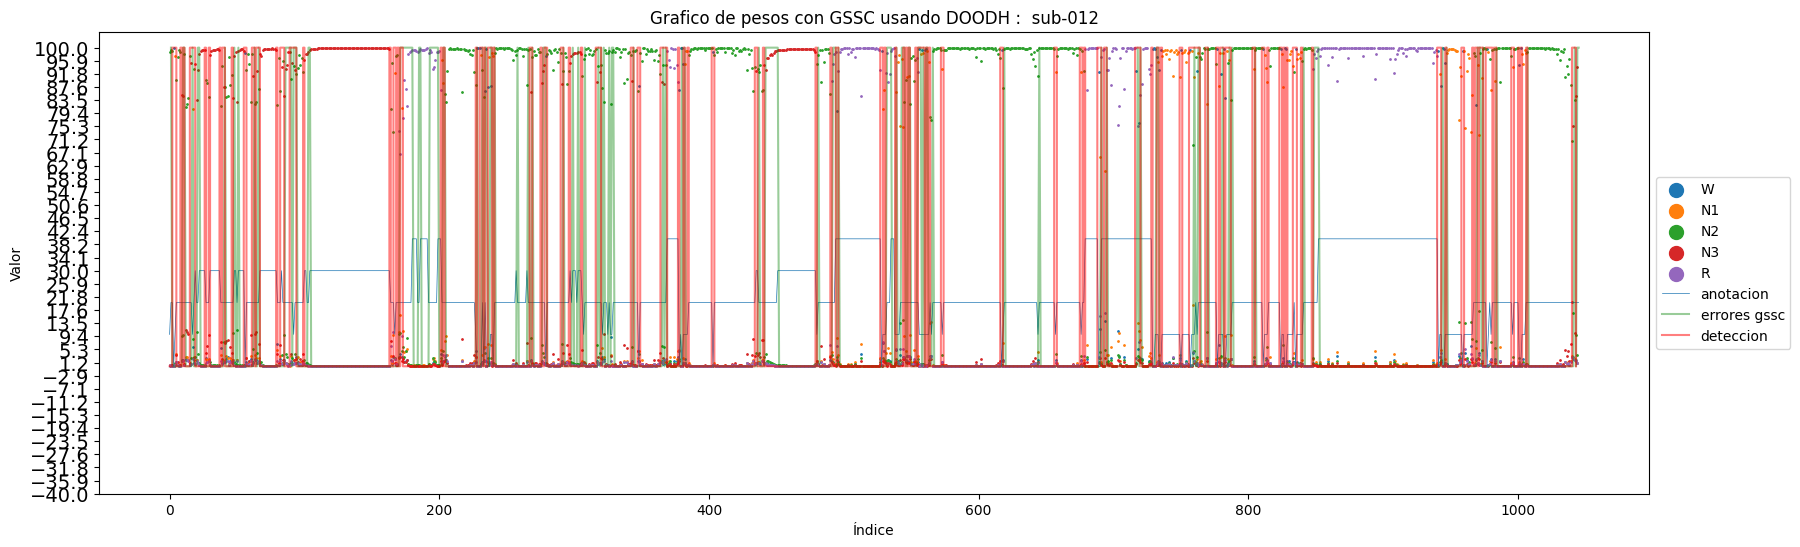

In [107]:

mapaDODH = {'NREM1' :1, 'NREM2':2, 'NREM3':3, 'NREM4' : 3, 'REM':4, 'WAKE':0,'NO_IDENTIFICADO' : 0}

import re
patron = re.compile(r'sub-\d+')
mapa_anot = {0: 0, 1: 20, 2: 40, 3: 70, 4: 80}
directorio = r'C:\Users\Bruno\OneDrive\Escritorio\Proyecto\DODHGSSC_YASA'
os.listdir(directorio)
# Filtrar los archivos que coinciden con el patrón 'sub'
archivos_sub = [archivo for archivo in os.listdir(directorio) if 'sub'  in archivo ]
# Separar los archivos en dos listas: gssc y yasa
archivos_gssc = [archivo for archivo in archivos_sub if 'gssc' in archivo]
archivos_yasa = [archivo for archivo in archivos_sub if 'yasa' in archivo]


df = pd.read_csv(os.path.join(directorio,archivos_yasa[11]), sep = '\t') 
df2 = pd.read_csv(os.path.join(directorio,archivos_gssc[11]), sep = '\t') 

############
data_gssc = pd.read_csv(os.path.join(directorio,archivos_gssc[11]), sep = '\t')
data_yasa =  pd.read_csv(os.path.join(directorio,archivos_yasa[11]), sep = '\t')

detecciones = Detec_Classif(df2)

anotacion_gssc = data_gssc['anotaciones']
anotaciones_yasa = data_yasa['anotaciones']

No_concidencias = [100 if epoch_gssc != epoch_yasa else 0 for epoch_gssc, epoch_yasa in zip(anotacion_gssc, anotaciones_yasa)]
################
df_drop= df.drop(columns='anotaciones')
df2_drop= df2.drop(columns='anotaciones')

detecciones2 = Detec_Classif2(df2_drop) # umbral para gssc 
#detecciones3 = Detec_Classif2(data_drop)
detecciones4 = Detec_Classif3_yasa(df_drop) # umbral yasa
lista_combinada = [max(a, b) for a, b in zip(detecciones2, detecciones4)]

#############################  
sujeto = 'sub-012'
path_annot = os.path.join(dic_DODH, sujeto,'ses-001','eeg',sujeto +'_'+ 'ses-001'+'_task-sleep_events.tsv')
anotaciones_real  = pd.read_csv(path_annot, sep  = '\t')


hipno = salida_predicha(anotaciones_real)
y_real =[int(mapaDODH.get(data)) for data in hipno]

# Comparar las dos listas y crear la lista de coincidencias

coincidencias = [0 if real == pred else 100 for real, pred in zip(y_real,df['anotaciones'])]
#########################
coincidencias1 = [0 if real == pred else 100 for real, pred in zip(y_real,data_gssc['anotaciones'])]
coincidencias2 = [0 if real == pred else 100 for real, pred in zip(y_real,data_yasa['anotaciones'])]
#########################

""""""""""""""""
# Crear un array de ceros del mismo tamaño que incertidumbre
ventana = np.zeros_like(df.index)

# Definir el tamaño de la ventana
longitud_ventana =5

# Definir la posición de la ventana (inicio)
inicio = 100
# Asegurarse de que la ventana no se sale de los límites
if inicio + longitud_ventana > ventana.shape[0]:
    raise ValueError("La ventana se sale de los límites del array")

# Llenar la región definida con unos
ventana[inicio:inicio + longitud_ventana] = 100
"""""""""""""""""

plt.figure(figsize=(20, 6))

plt.scatter(df2.index, df2['W'], label='W',s=  1)
plt.scatter(df2.index, df2['N1'], label='N1',s=  1)
plt.scatter(df2.index, df2['N2'], label='N2',s=  1)
plt.scatter(df2.index, df2['N3'], label='N3',s=  1)
plt.scatter(df2.index, df2['R'], label='R',s=  1)

anotaciones = [data*10 for data in y_real]
plt.plot(df.index, anotaciones, label='anotacion' ,linewidth=0.5)
change_points = [100  if  (data_gssc['anotaciones'][i] != data_gssc['anotaciones'][i-1]  ) else 0 for i in range(1, len(data_gssc['anotaciones']))]

# Asegúrate de invertir la lista resultante para mantener el orden correcto
#plt.plot(df.index[2:], change_points, color='red', label='detec cruce cero anotacion gssc', alpha  = 0.4)
#plt.plot(df.index, coincidencias, color='green', label='Real', alpha  = 0.4)
plt.plot(df.index[1:], coincidencias1, color='green', label='errores gssc', alpha  = 0.4)
#plt.plot(df.index, coincidencias2, color='red', label='yasa', alpha  = 0.4)

plt.plot(change_points, drawstyle='steps-post', label='deteccion', color='red', alpha =0.5)
#plt.plot(detecciones4, drawstyle='steps-post', label='deteccion', color='blue', alpha =0.5)
#plt.plot(lista_combinada, drawstyle='steps-post', label='comb umbrales yasa gssc', color='red', alpha =0.5)


#plt.plot(No_concidencias, drawstyle='steps-post', label='no concidencia gssc yasa', color='red', alpha =0.5)

#plt.scatter(std_ven.index,variabilidad,s=  5)
#plt.plot(incertidumbre3, drawstyle='steps-post', label='Real', color='blue', alpha =0.5)

#plt.plot(ventana, color='red', alpha  = 0.7)
#plt.scatter(std_ven.index,diferencia,s=  3)


plt.yticks(np.linspace(-40, 100, 35)) 

plt.xlabel('Índice')
plt.ylabel('Valor')
idx = patron.search(sujeto)[0]
plt.title(f'Grafico de pesos con GSSC usando DOODH :  {idx}')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), markerscale=10)
#plt.savefig(rf'C:\Users\Bruno\OneDrive\Escritorio\Proyecto\Pesos\SleepCasset\{idx}.png', bbox_inches='tight')
plt.tick_params(axis='y', which='major', labelsize=14)

plt.show()

In [108]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import re
cm4 = confusion_matrix(coincidencias1,lista_combinada)
tn, fp, fn, tp = cm4.ravel()
# tn, fp, fn, tp
print(tn, fp, fn, tp)
#715 194 52 82
#787 123 61 74

744 166 52 83


In [85]:
np.sum(change_points)/100

276.0

In [86]:
np.sum(coincidencias1)/100

135.0

In [74]:
np.sum(detecciones)/100

95.0

In [26]:
data = [0 if v1 == v2 else 1 for v1, v2 in zip(coincidencias2,coincidencias1)]
np.sum(data)
    

88

## PRUEBA FINAL VOTE 

In [49]:
from  Pipeline import  *
from ClasificadoresEnsamblados  import ClassifGSSC, ClassifYASA
from DetectoresEnsamblados import SpindleDetect


In [ ]:
dic_dod = r'H:\Mi unidad\FormatoBIDS\DatasetDODH'
path = os.path.join(dic_dod, 'sub-001','ses-001','eeg','sub-001' +'_'+ 'ses-001'+'_task-sleep_eeg.edf')
raw = mne.io.read_raw_edf(path, preload =  True)


sujeto = 'sub-001'
path_annot = os.path.join(r'H:\Mi unidad\FormatoBIDS\DatasetDODH', sujeto,'ses-001','eeg',sujeto +'_'+ 'ses-001'+'_task-sleep_events.tsv') ###
anotaciones_real  = pd.read_csv(path_annot, sep  = '\t')

hipno = salida_predicha(anotaciones_real)
mapaDODH = {'NREM1' :1, 'NREM2':2, 'NREM3':3, 'NREM4' : 3, 'REM':4, 'WAKE':0,'NO_IDENTIFICADO' : 0}
y_real =[int(mapaDODH.get(data)) for data in hipno]

classifiers = {
    'GSSC': ClassifGSSC, 
    'YASA': ClassifYASA,
    
}
metadataDODH = {'channels' : { 'eog' : ['EOG1', 'EOG2' ], 'eeg': {'central':['C3_M2'],'frontal' : ['F3_M2', 'F4_M1', 'FP1_M2', 'FP2_M1'], 'parietal' : []}, 'emg':['EMG'] }}

result = classify_file( raw, metadataDODH, classifiers)


In [29]:
def Final_Vote(results):
    """_summary_

    Args:
        results (dic): diccionario donde la key es el nombre del clasificador, el primer elemento del diccionario
        son los pesos para cada clase y el 2do elemento son las anotaciones de la etapa del sueño
    """

    
   

    for name in results.keys():
        if name == 'GSSC':
            pesos_gssc  = results[name][0]
            anotaciones_gssc = results[name][1]
        if name =='YASA' :
            pesos_yasa  = results[name][0]
            anotaciones_yasa = results[name][1]
    
    No_concidencias = [1 if epoch_gssc != epoch_yasa else 0 for epoch_gssc, epoch_yasa in zip(anotaciones_gssc, anotaciones_yasa)]
    Candidatos_a_revision = No_concidencias
    
    if sum(No_concidencias) > sum(anotaciones_gssc)*0.3 :  # en estas lineas de codigo se implementa la estrategia de usar los pesos de gssc
        # para epocas candidatas a revision, solo se hara uso de esta estrategia cuando la implemntacin de las no coincidencias
        # de un numero mayor al 0.3 del raw completo dele estudio
        
        # Definir los criterios de incertidumbre
        criteria = {
            'W': 98,
            'N1': 0,
            'N2': 96,
            'N3': 97,
            'R': 96
        }

        # Crear una lista para almacenar los resultados de incertidumbre
        incertidumbre = []

        # Iterar sobre cada fila del DataFrame
        for index, row in pesos_gssc.iterrows():
            # Encontrar la columna con el valor máximo
            max_col = row.idxmax(axis=0)
            # Comprobar si el valor máximo cumple con el criterio de incertidumbre
            if row[max_col] < criteria[max_col]:
                incertidumbre.append(100)
            else:
                incertidumbre.append(0)

        Candidatos_a_revision = incertidumbre

        ################# ME FALTA GENERAQR EL CANAL STIM CON ELA RCHIVO Y PROBAR ESTA FUNCION POR SEPARADO ####################  
    # devuelve el archivo raw con un canal de stim donde se indica cuales eventos 
    #fueron detectados con poca presicion en ambois modelos de acuerdoa  algun criterio
    
  # genero un canal stim y agrego los eventos

    pre_stim =np.zeros_like(np.array(np.arange(raw.n_times))) #[:,:][0][0]
    """
    pre_stim[onsets_] = 1
    stim_chan = pre_stim.reshape(1,-1)

    mask_info = mne.create_info(ch_names=["STIMcomplexK"],
                                sfreq=raw.info["sfreq"],
                                ch_types=["stim"]
                            )
    raw_mask = mne.io.RawArray(data=stim_chan,
                            info=mask_info,
                            first_samp=raw.first_samp
                            )
    raw.add_channels([raw_mask], force_update_info=True)
   """

'C3_M2'

In [52]:
SpindleDetect(raw,raw.info.ch_names[0])

In [48]:
pre_stim =np.zeros_like(np.array(np.arange(raw.n_times))) #[:,:][0][0]
(pre_stim.shape[0]/raw.info['sfreq'])
raw.n_times

7260000